### Machine Learning Pipeline: Feature Selection and Hyperparameter Optimization

Bu kapsamlı rehber, HIGGS Dataset üzerinde özellik seçimi ve hiperparametre optimizasyonu süreçlerini içeren makine öğrenmesi pipeline'ının tam implementasyonunu sunmaktadır. Proje, veri ön işlemeden model değerlendirmesine kadar tüm adımları detaylı kod örnekleri ile birlikte açıklamaktadır.

In [2]:
# Gerekli kütüphanelerin yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (StratifiedKFold, GridSearchCV,
                                   train_test_split, cross_val_score)
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, roc_curve, classification_report)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


### Veri Yükleme ve Keşifsel Veri Analizi

HIGGS veri seti yükleniyor...
HIGGS.csv dosyası bulunamadı. Örnek veri seti oluşturuluyor...
Simüle edilmiş veri seti boyutu: (100000, 29)
Sınıf dağılımı:
label
1    50136
0    49864
Name: count, dtype: int64

**Veri Seti Temel İstatistikleri:**
               label      feature_1      feature_2      feature_3  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.501360       0.074464       0.130401       0.127784   
std         0.500001       1.006339       1.015831       1.017680   
min         0.000000      -4.431939      -4.359826      -4.330022   
25%         0.000000      -0.605853      -0.554299      -0.563319   
50%         1.000000       0.070971       0.128735       0.130918   
75%         1.000000       0.751164       0.814751       0.814233   
max         1.000000       4.517489       4.896783       4.381237   

           feature_4      feature_5      feature_6      feature_7  \
count  100000.000000  100000.000000  100000.000000  100000.0000

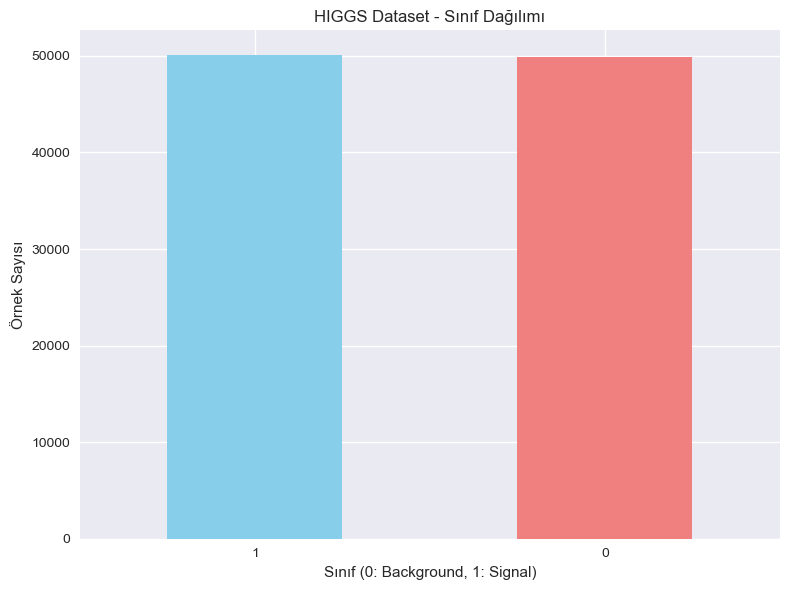

In [3]:
def load_higgs_dataset():
    """
    HIGGS veri setini yükler ve 100,000 rastgele örnek seçer
    """
    try:
        # Gerçek HIGGS veri setini yükleme
        # Veri seti: https://archive.ics.uci.edu/ml/datasets/HIGGS
        print("HIGGS veri seti yükleniyor...")

        # Veri setinde sütun isimleri yok, manuel olarak ekliyoruz
        column_names = ['label'] + [f'feature_{i}' for i in range(1, 29)]

        # 100,000 örnek yükleme
        data = pd.read_csv('HIGGS.csv', nrows=100000, header=None, names=column_names)

        print(f"Veri seti boyutu: {data.shape}")
        print(f"Sınıf dağılımı:\n{data['label'].value_counts()}")
        print(f"Sınıf dağılımı (yüzde):\n{data['label'].value_counts(normalize=True) * 100}")

        return data

    except FileNotFoundError:
        print("HIGGS.csv dosyası bulunamadı. Örnek veri seti oluşturuluyor...")
        # Gerçek veri yoksa simülasyon için örnek veri
        np.random.seed(42)
        n_samples, n_features = 100000, 28

        # Gerçekçi veri dağılımı için farklı özellikler
        X_synthetic = np.random.randn(n_samples, n_features)
        # Bazı özellikleri hedef değişkenle korelasyonlu hale getirme
        correlation_strength = np.random.uniform(0.1, 0.3, n_features)
        y_synthetic = np.random.binomial(1, 0.5, n_samples)

        for i in range(n_features):
            X_synthetic[:, i] += correlation_strength[i] * y_synthetic + np.random.normal(0, 0.1, n_samples)

        column_names = ['label'] + [f'feature_{i}' for i in range(1, 29)]
        data = pd.DataFrame(X_synthetic, columns=column_names[1:])
        data['label'] = y_synthetic

        # Sütunları yeniden düzenleme
        data = data[column_names]

        print(f"Simüle edilmiş veri seti boyutu: {data.shape}")
        print(f"Sınıf dağılımı:\n{data['label'].value_counts()}")

        return data

# Veri setini yükleme
data = load_higgs_dataset()

# Temel istatistiksel analiz
print("\n**Veri Seti Temel İstatistikleri:**")
print(data.describe())

# Eksik değer kontrolü
print(f"\nEksik değer kontrolü:")
print(f"Toplam eksik değer: {data.isnull().sum().sum()}")

# Sınıf dağılımının görselleştirilmesi
plt.figure(figsize=(8, 6))
data['label'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('HIGGS Dataset - Sınıf Dağılımı')
plt.xlabel('Sınıf (0: Background, 1: Signal)')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Veri Ön İşleme (Preprocessing)

Veri ön işleme aşaması, model performansını doğrudan etkileyen kritik bir adımdır. Bu bölümde aykırı değer analizi ve özellik ölçekleme işlemleri gerçekleştirilecektir.

#### Aykırı Değer Analizi (IQR Yöntemi)


**Aykırı Değer Analizi Sonuçları:**
feature_1: 760 aykırı değer (0.76%)
feature_2: 731 aykırı değer (0.73%)
feature_3: 683 aykırı değer (0.68%)
feature_4: 680 aykırı değer (0.68%)
feature_5: 738 aykırı değer (0.74%)
feature_6: 693 aykırı değer (0.69%)
feature_7: 685 aykırı değer (0.69%)
feature_8: 746 aykırı değer (0.75%)
feature_9: 720 aykırı değer (0.72%)
feature_10: 693 aykırı değer (0.69%)
feature_11: 690 aykırı değer (0.69%)
feature_12: 668 aykırı değer (0.67%)
feature_13: 661 aykırı değer (0.66%)
feature_14: 668 aykırı değer (0.67%)
feature_15: 641 aykırı değer (0.64%)
feature_16: 707 aykırı değer (0.71%)
feature_17: 720 aykırı değer (0.72%)
feature_18: 723 aykırı değer (0.72%)
feature_19: 730 aykırı değer (0.73%)
feature_20: 738 aykırı değer (0.74%)
feature_21: 702 aykırı değer (0.70%)
feature_22: 707 aykırı değer (0.71%)
feature_23: 736 aykırı değer (0.74%)
feature_24: 734 aykırı değer (0.73%)
feature_25: 701 aykırı değer (0.70%)
feature_26: 723 aykırı değer (0.72%)
feature_27:

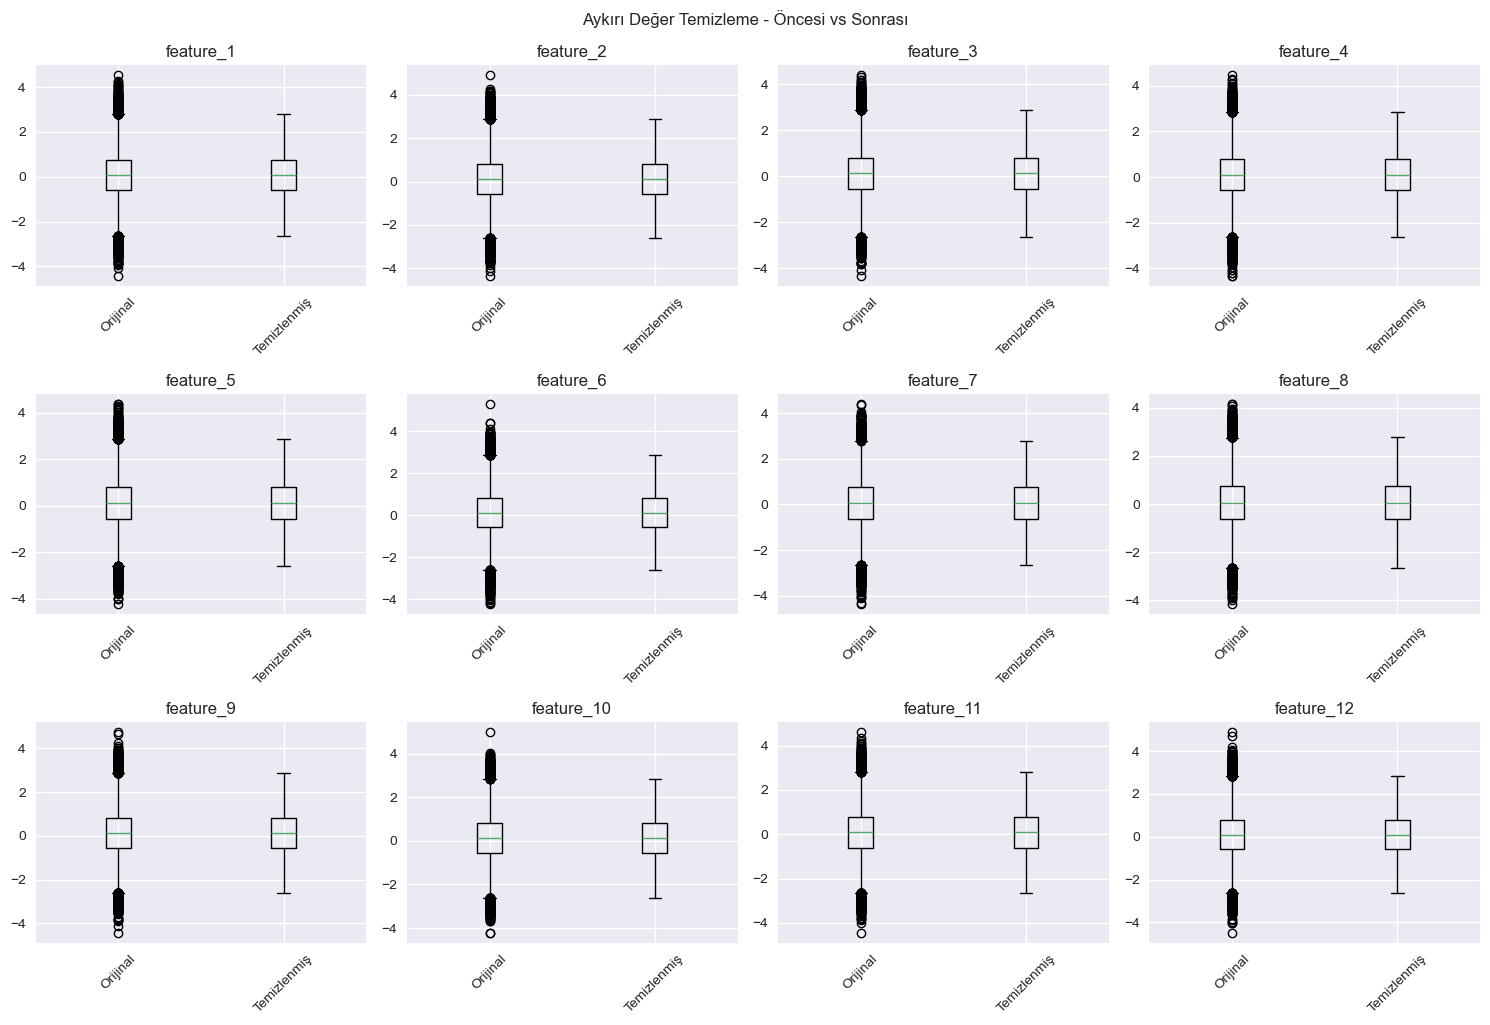

In [4]:
def detect_and_handle_outliers(data, method='winsorize'):
    """
    IQR yöntemi ile aykırı değerleri tespit eder ve işler
    """
    data_processed = data.copy()
    feature_columns = [col for col in data.columns if col != 'label']

    outlier_summary = {}

    print("**Aykırı Değer Analizi Sonuçları:**")

    for col in feature_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Aykırı değerleri tespit etme
        outliers_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
        outlier_count = outliers_mask.sum()
        outlier_percentage = (outlier_count / len(data)) * 100

        outlier_summary[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        if outlier_count > 0:
            print(f"{col}: {outlier_count} aykırı değer ({outlier_percentage:.2f}%)")

            if method == 'winsorize':
                # Winsorization: Aykırı değerleri sınır değerlerle değiştirme
                data_processed.loc[data_processed[col] < lower_bound, col] = lower_bound
                data_processed.loc[data_processed[col] > upper_bound, col] = upper_bound
            elif method == 'remove':
                # Aykırı değerleri silme (dikkatli kullanılmalı)
                data_processed = data_processed[~outliers_mask]
        else:
            print(f"{col}: Aykırı değer tespit edilmedi")

    return data_processed, outlier_summary

# Aykırı değer analizi ve işleme
data_cleaned, outlier_info = detect_and_handle_outliers(data, method='winsorize')

print(f"\nVeri temizleme sonuçları:")
print(f"Orijinal veri boyutu: {data.shape}")
print(f"Temizlenmiş veri boyutu: {data_cleaned.shape}")

# Aykırı değer dağılımının görselleştirilmesi
plt.figure(figsize=(15, 10))
feature_columns = [col for col in data.columns if col != 'label']
sample_features = feature_columns[:12]  # İlk 12 özellik

for i, col in enumerate(sample_features):
    plt.subplot(3, 4, i+1)
    plt.boxplot([data[col], data_cleaned[col]], labels=['Orijinal', 'Temizlenmiş'])
    plt.title(f'{col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('Aykırı Değer Temizleme - Öncesi vs Sonrası', y=1.02)
plt.show()


### Özellik Ölçekleme (MinMaxScaler)

Özellik ölçekleme, farklı ölçeklerdeki özniteliklerin model eğitiminde eşit ağırlığa sahip olmasını sağlar. MinMaxScaler, değerleri [0, 1] aralığına dönüştürür:

**Özellik Ölçekleme Sonuçları:**
Ölçekleme öncesi - Min: -2.672, Max: 2.881
Ölçekleme sonrası - Min: 0.000, Max: 1.000


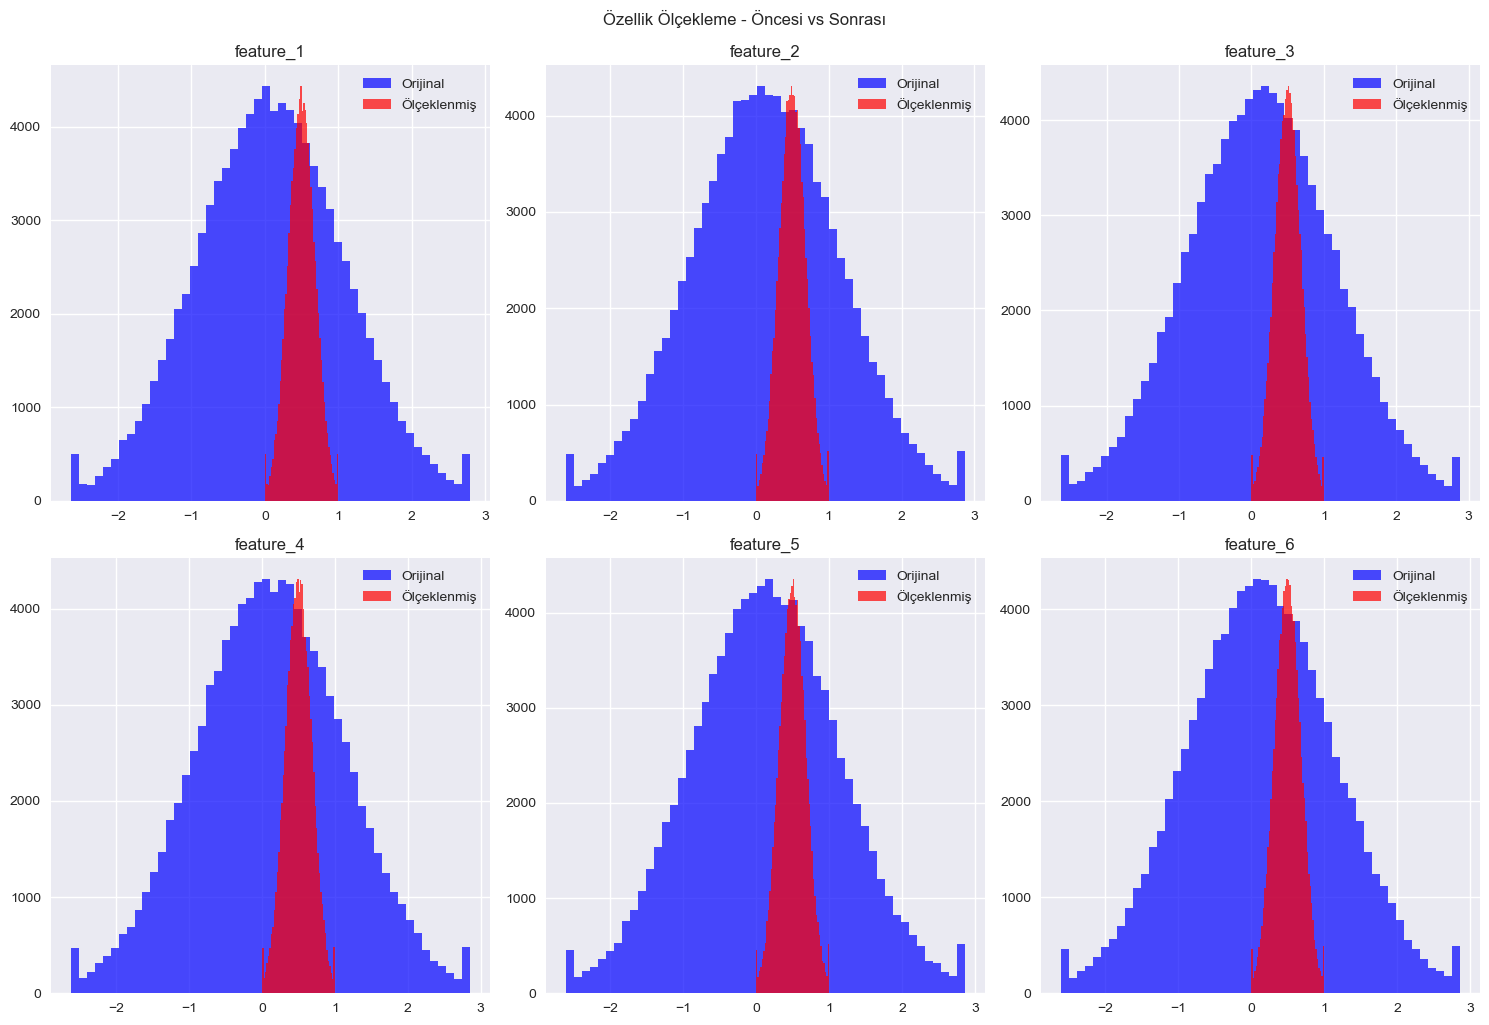

In [5]:
# Özellik ve hedef değişkenlerin ayrılması
X = data_cleaned.drop('label', axis=1)
y = data_cleaned['label']

# MinMaxScaler ile ölçekleme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("**Özellik Ölçekleme Sonuçları:**")
print(f"Ölçekleme öncesi - Min: {X.min().min():.3f}, Max: {X.max().max():.3f}")
print(f"Ölçekleme sonrası - Min: {X_scaled.min().min():.3f}, Max: {X_scaled.max().max():.3f}")

# Ölçekleme öncesi ve sonrası karşılaştırma
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sample_features = X.columns[:6]

for i, col in enumerate(sample_features):
    row = i // 3
    col_idx = i % 3

    axes[row, col_idx].hist(X[col], alpha=0.7, label='Orijinal', bins=50, color='blue')
    axes[row, col_idx].hist(X_scaled[col], alpha=0.7, label='Ölçeklenmiş', bins=50, color='red')
    axes[row, col_idx].set_title(f'{col}')
    axes[row, col_idx].legend()

plt.tight_layout()
plt.suptitle('Özellik Ölçekleme - Öncesi vs Sonrası', y=1.02)
plt.show()


### Özellik Seçimi (Feature Selection)

Özellik seçimi, model performansını artırmak ve hesaplama maliyetini azaltmak için en bilgilendirici özelliklerin belirlenmesi sürecidir. Bu projede hem ANOVA F-score hem de Mutual Information yöntemleri kullanılacaktır.


**ANOVA F-score ile Seçilen En İyi 15 Özellik:**
   Feature       Score
feature_18 2245.948215
feature_21 1751.067995
 feature_3 1742.148110
feature_17 1613.986784
 feature_9 1607.066878
feature_10 1588.383023
 feature_6 1573.563635
 feature_5 1572.111489
 feature_2 1571.581604
feature_28 1207.801201
 feature_4 1178.975635
feature_25 1098.503312
feature_14 1055.438016
feature_12 1036.068389
feature_13  985.145327

**Mutual Information ile Seçilen En İyi 15 Özellik:**
   Feature    Score
feature_18 0.013987
feature_21 0.010093
 feature_5 0.009479
feature_17 0.008728
 feature_3 0.008139
 feature_9 0.008057
 feature_2 0.007222
 feature_6 0.006564
feature_10 0.006481
feature_14 0.006433
feature_27 0.005864
 feature_4 0.005746
feature_25 0.005453
feature_22 0.005263
feature_13 0.005229


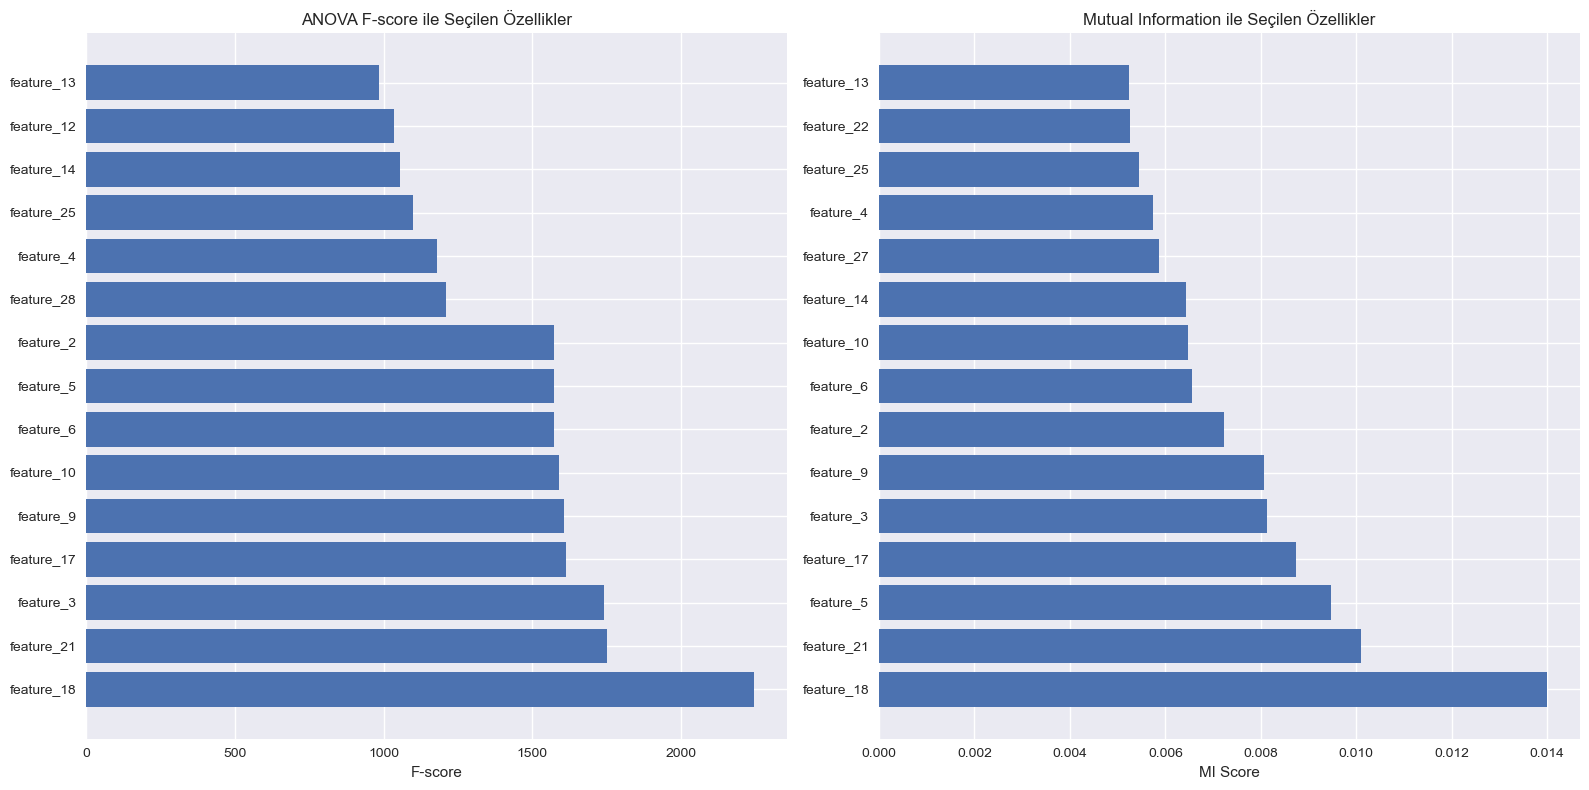

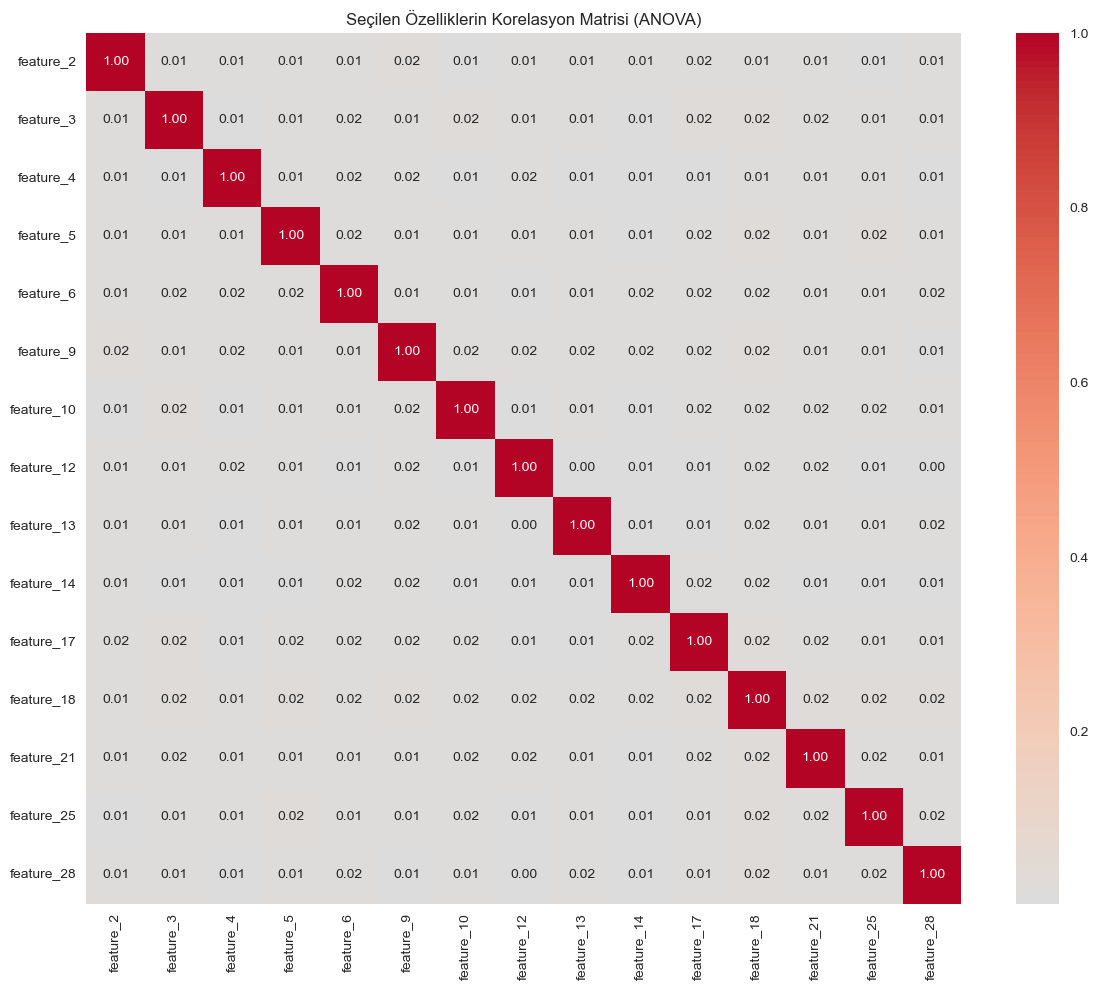

In [6]:
def perform_feature_selection(X, y, method='anova', k=15):
    """
    Filter-based özellik seçimi gerçekleştirir
    """
    if method == 'anova':
        selector = SelectKBest(score_func=f_classif, k=k)
        method_name = 'ANOVA F-score'
    elif method == 'mutual_info':
        selector = SelectKBest(score_func=mutual_info_classif, k=k)
        method_name = 'Mutual Information'
    else:
        raise ValueError("Method 'anova' veya 'mutual_info' olmalıdır")

    # Özellik seçimi
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    feature_scores = selector.scores_

    # Sonuçları DataFrame'e dönüştürme
    results_df = pd.DataFrame({
        'Feature': X.columns,
        'Score': feature_scores,
        'Selected': selector.get_support()
    }).sort_values('Score', ascending=False)

    selected_results = results_df[results_df['Selected']].head(k)

    print(f"\n**{method_name} ile Seçilen En İyi {k} Özellik:**")
    print(selected_results[['Feature', 'Score']].to_string(index=False))

    return X_selected, selected_features, results_df, selector

# ANOVA F-score ile özellik seçimi
X_anova, features_anova, results_anova, selector_anova = perform_feature_selection(
    X_scaled, y, method='anova', k=15
)

# Mutual Information ile özellik seçimi
X_mutual, features_mutual, results_mutual, selector_mutual = perform_feature_selection(
    X_scaled, y, method='mutual_info', k=15
)

# Özellik skorlarının görselleştirilmesi
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ANOVA F-score sonuçları
selected_anova = results_anova[results_anova['Selected']].head(15)
axes[0].barh(range(len(selected_anova)), selected_anova['Score'])
axes[0].set_yticks(range(len(selected_anova)))
axes[0].set_yticklabels(selected_anova['Feature'])
axes[0].set_title('ANOVA F-score ile Seçilen Özellikler')
axes[0].set_xlabel('F-score')

# Mutual Information sonuçları
selected_mutual = results_mutual[results_mutual['Selected']].head(15)
axes[1].barh(range(len(selected_mutual)), selected_mutual['Score'])
axes[1].set_yticks(range(len(selected_mutual)))
axes[1].set_yticklabels(selected_mutual['Feature'])
axes[1].set_title('Mutual Information ile Seçilen Özellikler')
axes[1].set_xlabel('MI Score')

plt.tight_layout()
plt.show()

# Seçilen özelliklerin korelasyon matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = pd.DataFrame(X_anova, columns=features_anova).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Seçilen Özelliklerin Korelasyon Matrisi (ANOVA)')
plt.tight_layout()
plt.show()


### Nested Cross-Validation ile Model Değerlendirmesi

Nested Cross-Validation, hem hiperparametre optimizasyonu hem de modelin genelleme performansının güvenilir bir şekilde değerlendirilmesi için kullanılan sağlam bir yöntemdir.

In [7]:
class NestedCrossValidation:
    """
    Nested Cross-Validation implementasyonu
    """

    def __init__(self, outer_cv=5, inner_cv=3, random_state=42):
        self.outer_cv = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=random_state)
        self.inner_cv = StratifiedKFold(n_splits=inner_cv, shuffle=True, random_state=random_state)
        self.results = {}
        self.roc_data = {}

    def evaluate_model(self, model, param_grid, X, y, model_name):
        """
        Nested CV ile model değerlendirmesi
        """
        print(f"\n--- {model_name} Modeli Değerlendiriliyor ---")

        # Metrik listeleri
        fold_results = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []
        }

        best_params_list = []
        roc_curves = []

        # Dış döngü
        for fold_idx, (train_outer_idx, test_outer_idx) in enumerate(self.outer_cv.split(X, y)):
            print(f"  Dış Fold {fold_idx + 1}/5")

            X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
            y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]

            # İç döngü ile hiperparametre optimizasyonu
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=self.inner_cv,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=0
            )

            grid_search.fit(X_train_outer, y_train_outer)
            best_model = grid_search.best_estimator_
            best_params_list.append(grid_search.best_params_)

            # Dış test seti üzerinde değerlendirme
            y_pred = best_model.predict(X_test_outer)
            y_pred_proba = best_model.predict_proba(X_test_outer)[:, 1]

            # Metriklerin hesaplanması
            fold_results['accuracy'].append(accuracy_score(y_test_outer, y_pred))
            fold_results['precision'].append(precision_score(y_test_outer, y_pred))
            fold_results['recall'].append(recall_score(y_test_outer, y_pred))
            fold_results['f1'].append(f1_score(y_test_outer, y_pred))
            fold_results['roc_auc'].append(roc_auc_score(y_test_outer, y_pred_proba))

            # ROC eğrisi verilerini toplama
            fpr, tpr, _ = roc_curve(y_test_outer, y_pred_proba)
            roc_curves.append((fpr, tpr, roc_auc_score(y_test_outer, y_pred_proba)))

            print(f"    En iyi hiperparametreler: {grid_search.best_params_}")
            print(f"    ROC-AUC: {roc_auc_score(y_test_outer, y_pred_proba):.4f}")

        # Sonuçları kaydetme
        self.results[model_name] = {
            'fold_scores': fold_results,
            'mean_scores': {metric: np.mean(scores) for metric, scores in fold_results.items()},
            'std_scores': {metric: np.std(scores) for metric, scores in fold_results.items()},
            'best_params': best_params_list
        }

        # ROC eğrisi verilerini kaydetme (ortalama ROC eğrisi hesaplama)
        self.roc_data[model_name] = self._calculate_mean_roc(roc_curves)

        # Sonuçları yazdırma
        print(f"\n  {model_name} Sonuçları:")
        for metric, mean_score in self.results[model_name]['mean_scores'].items():
            std_score = self.results[model_name]['std_scores'][metric]
            print(f"    {metric.upper()}: {mean_score:.4f} ± {std_score:.4f}")

        return self.results[model_name]

    def _calculate_mean_roc(self, roc_curves):
        """
        Ortalama ROC eğrisi hesaplar
        """
        # Ortak FPR değerleri
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        for fpr, tpr, auc in roc_curves:
            # TPR değerlerini ortak FPR değerlerine interpolate etme
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(auc)

        # Ortalama TPR ve AUC
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        return {
            'fpr': mean_fpr,
            'tpr': mean_tpr,
            'auc': mean_auc,
            'auc_std': std_auc
        }

# Model tanımlamaları ve hiperparametre aralıkları
models_config = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7, 9, 11]}
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear']} # RBF çok uzun sürdüğü için kernel kısmından çıkardım.
    },
    'MLP': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu', 'tanh']
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.2]
        }
    }
}

# Nested Cross-Validation ile model değerlendirmesi
nested_cv = NestedCrossValidation(outer_cv=5, inner_cv=3)

print("**ANOVA Özellik Seçimi ile Model Değerlendirmesi:**")
for model_name, config in models_config.items():
    nested_cv.evaluate_model(
        config['model'],
        config['params'],
        X_anova,
        y,
        f"{model_name}_ANOVA"
    )


**ANOVA Özellik Seçimi ile Model Değerlendirmesi:**

--- KNN_ANOVA Modeli Değerlendiriliyor ---
  Dış Fold 1/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6779
  Dış Fold 2/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6849
  Dış Fold 3/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6812
  Dış Fold 4/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6818
  Dış Fold 5/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6857

  KNN_ANOVA Sonuçları:
    ACCURACY: 0.6357 ± 0.0029
    PRECISION: 0.6364 ± 0.0028
    RECALL: 0.6378 ± 0.0032
    F1: 0.6371 ± 0.0029
    ROC_AUC: 0.6823 ± 0.0028

--- SVM_ANOVA Modeli Değerlendiriliyor ---
  Dış Fold 1/5
    En iyi hiperparametreler: {'C': 0.1, 'kernel': 'linear'}
    ROC-AUC: 0.7421
  Dış Fold 2/5
    En iyi hiperparametreler: {'C': 0.1, 'kernel': 'linear'}
    ROC-AUC: 0.7499
  Dış Fold 3/5
    En iyi hiperparametreler: {'C': 0.1, 'kernel': 'linear'}
 

### Sonuçların Analizi ve Görselleştirmesi

Model performanslarını karşılaştırmak ve sonuçları görselleştirmek için kapsamlı analiz araçları kullanılacaktır.

In [8]:
def create_results_summary(nested_cv_results):
    """
    Model sonuçlarını özet tablo halinde düzenler
    """
    summary_data = []

    for model_name, results in nested_cv_results.items():
        row = {
            'Model': model_name,
            'Accuracy': f"{results['mean_scores']['accuracy']:.4f} ± {results['std_scores']['accuracy']:.4f}",
            'Precision': f"{results['mean_scores']['precision']:.4f} ± {results['std_scores']['precision']:.4f}",
            'Recall': f"{results['mean_scores']['recall']:.4f} ± {results['std_scores']['recall']:.4f}",
            'F1-Score': f"{results['mean_scores']['f1']:.4f} ± {results['std_scores']['f1']:.4f}",
            'ROC-AUC': f"{results['mean_scores']['roc_auc']:.4f} ± {results['std_scores']['roc_auc']:.4f}"
        }
        summary_data.append(row)

    return pd.DataFrame(summary_data)


# Sonuç tablosunu oluşturma
results_table = create_results_summary(nested_cv.results)
print("\n**ANOVA Özellik Seçimi ile Model Performans Karşılaştırması:**")
print(results_table.to_string(index=False))


**ANOVA Özellik Seçimi ile Model Performans Karşılaştırması:**
        Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC
    KNN_ANOVA 0.6357 ± 0.0029 0.6364 ± 0.0028 0.6378 ± 0.0032 0.6371 ± 0.0029 0.6823 ± 0.0028
    SVM_ANOVA 0.6795 ± 0.0014 0.6803 ± 0.0022 0.6808 ± 0.0033 0.6805 ± 0.0014 0.7453 ± 0.0027
    MLP_ANOVA 0.6782 ± 0.0028 0.6843 ± 0.0097 0.6664 ± 0.0301 0.6746 ± 0.0113 0.7453 ± 0.0027
XGBoost_ANOVA 0.6735 ± 0.0025 0.6742 ± 0.0035 0.6750 ± 0.0034 0.6746 ± 0.0021 0.7391 ± 0.0032


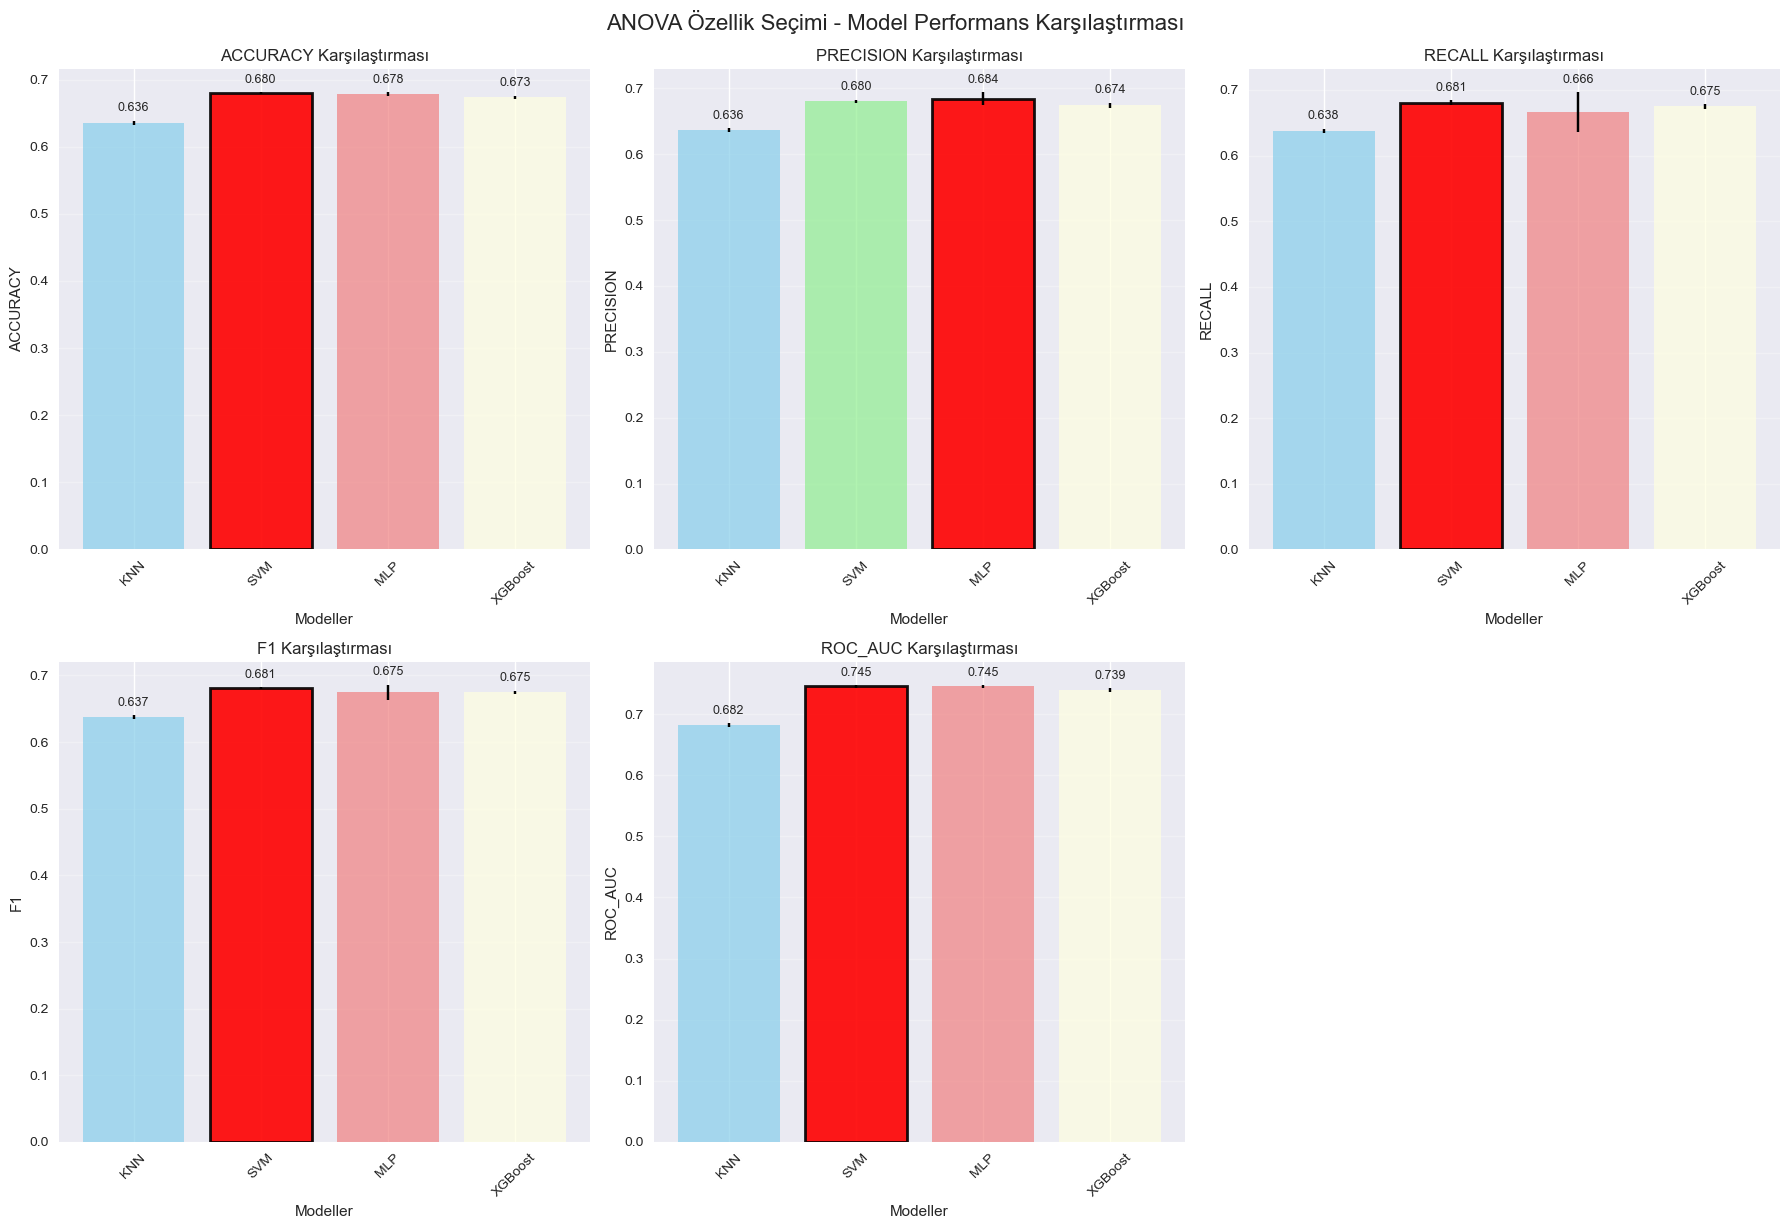

In [9]:
# Performans metriklerinin görselleştirilmesi
def plot_model_comparison(results):
    """
    Model performanslarını karşılaştıran kapsamlı görselleştirmeler
    """
    models = list(results.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        means = [results[model]['mean_scores'][metric] for model in models]
        stds = [results[model]['std_scores'][metric] for model in models]

        x_pos = np.arange(len(models))
        bars = axes[i].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7,
                          color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])

        # En iyi performansı vurgulama
        best_idx = np.argmax(means)
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(2)

        axes[i].set_xlabel('Modeller')
        axes[i].set_ylabel(metric.upper())
        axes[i].set_title(f'{metric.upper()} Karşılaştırması')
        axes[i].set_xticks(x_pos)
        axes[i].set_xticklabels([m.replace('_ANOVA', '') for m in models], rotation=45)
        axes[i].grid(axis='y', alpha=0.3)

        # Değerleri bar üzerine yazma
        for j, (mean, std) in enumerate(zip(means, stds)):
            axes[i].text(j, mean + std + 0.01, f'{mean:.3f}',
                        ha='center', va='bottom', fontsize=9)

    # Son subplot'u kaldırma
    fig.delaxes(axes[5])

    plt.tight_layout()
    plt.suptitle('ANOVA Özellik Seçimi - Model Performans Karşılaştırması', y=1.02, fontsize=16)
    plt.show()

plot_model_comparison(nested_cv.results)


### Mutual Information ile Özellik Seçimi ve Karşılaştırma

Projenin tam olması için hem ANOVA hem de Mutual Information özellik seçimi yöntemlerinin karşılaştırılması gerekmektedir.


**Mutual Information Özellik Seçimi ile Model Değerlendirmesi:**

--- KNN_MI Modeli Değerlendiriliyor ---
  Dış Fold 1/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6781
  Dış Fold 2/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6830
  Dış Fold 3/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6760
  Dış Fold 4/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6752
  Dış Fold 5/5
    En iyi hiperparametreler: {'n_neighbors': 11}
    ROC-AUC: 0.6843

  KNN_MI Sonuçları:
    ACCURACY: 0.6334 ± 0.0037
    PRECISION: 0.6342 ± 0.0038
    RECALL: 0.6353 ± 0.0041
    F1: 0.6347 ± 0.0037
    ROC_AUC: 0.6793 ± 0.0037

--- SVM_MI Modeli Değerlendiriliyor ---
  Dış Fold 1/5
    En iyi hiperparametreler: {'C': 10, 'kernel': 'linear'}
    ROC-AUC: 0.7401
  Dış Fold 2/5
    En iyi hiperparametreler: {'C': 1, 'kernel': 'linear'}
    ROC-AUC: 0.7476
  Dış Fold 3/5
    En iyi hiperparametreler: {'C': 1, 'kernel': 'linear'}
 

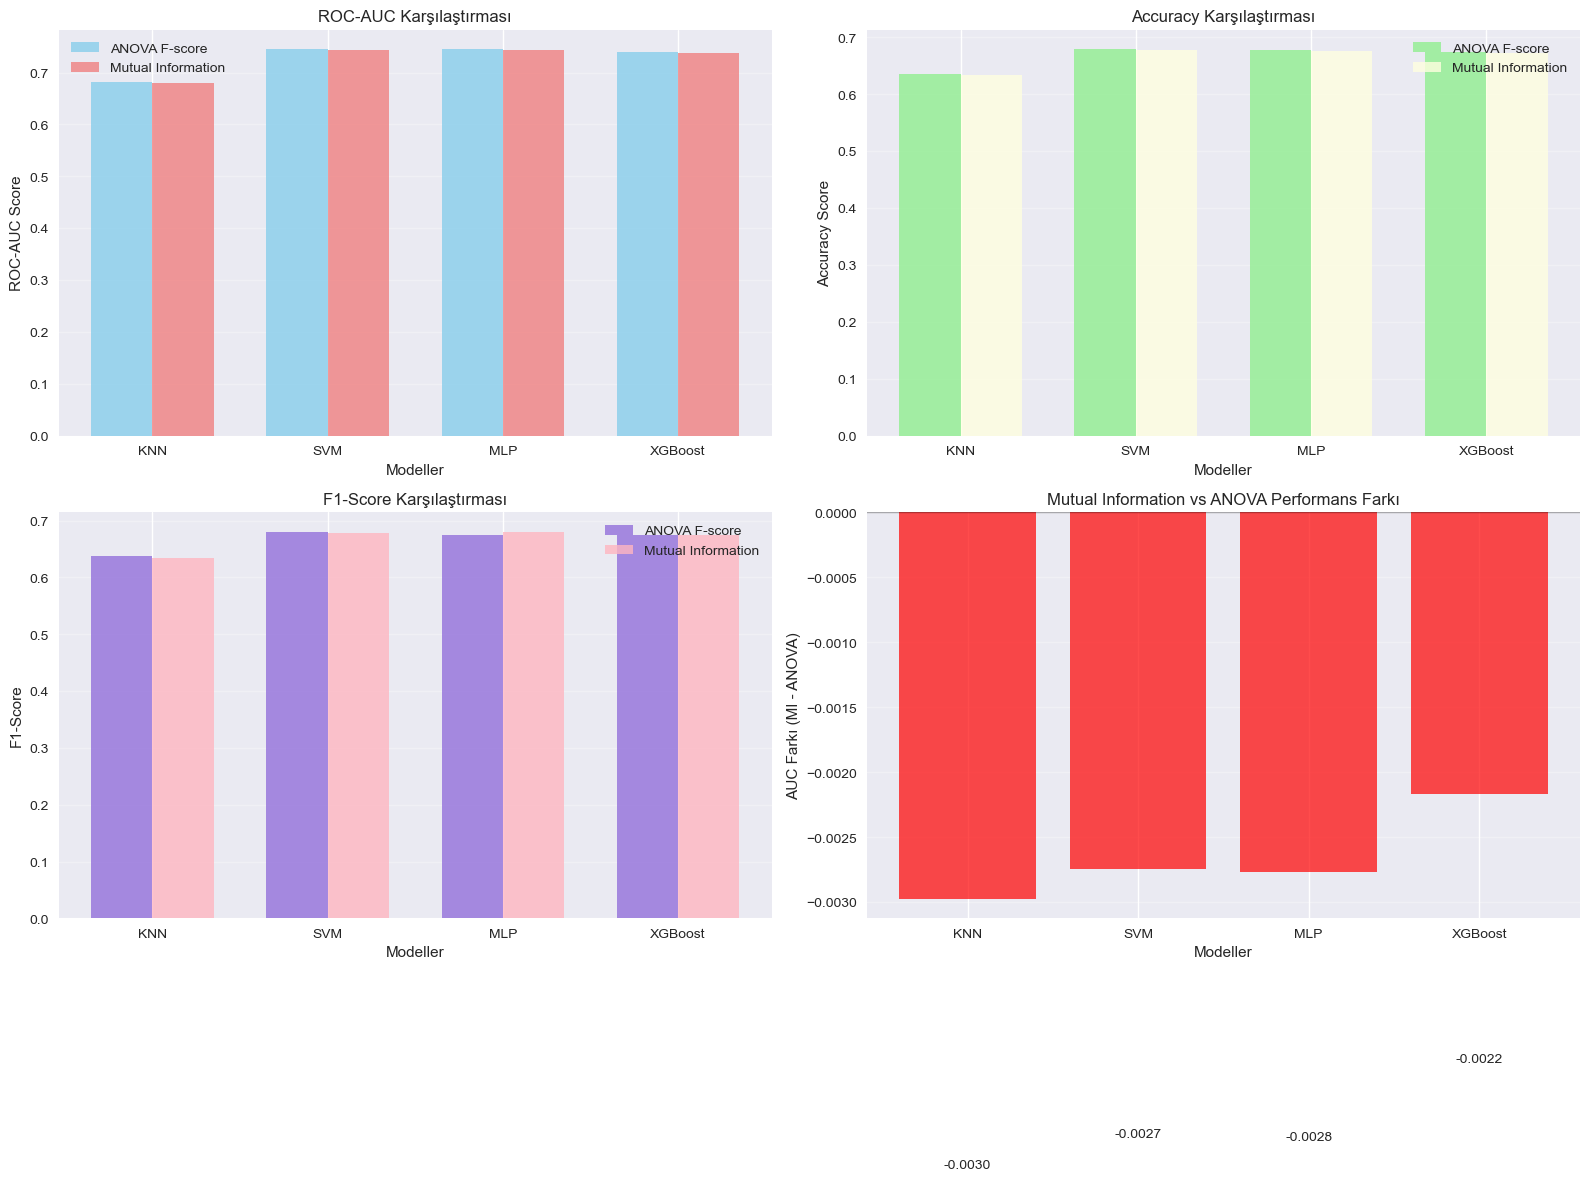

In [10]:
# Mutual Information ile seçilen özelliklerle Nested CV
nested_cv_mutual = NestedCrossValidation(outer_cv=5, inner_cv=3)

print("\n**Mutual Information Özellik Seçimi ile Model Değerlendirmesi:**")
for model_name, config in models_config.items():
    nested_cv_mutual.evaluate_model(
        config['model'],
        config['params'],
        X_mutual,
        y,
        f"{model_name}_MI"
    )

# Mutual Information sonuçlarının tablosu
results_table_mi = create_results_summary(nested_cv_mutual.results)
print("\n**Mutual Information ile Model Performans Karşılaştırması:**")
print(results_table_mi.to_string(index=False))

# İki özellik seçim yönteminin karşılaştırılması
def compare_feature_selection_methods(results_anova, results_mi):
    """
    ANOVA ve Mutual Information yöntemlerini detaylı karşılaştırır
    """
    comparison_data = []

    # Model isimlerini temizleme
    anova_models = {k.replace('_ANOVA', ''): v for k, v in results_anova.items()}
    mi_models = {k.replace('_MI', ''): v for k, v in results_mi.items()}

    for model_name in anova_models.keys():
        if model_name in mi_models:
            anova_metrics = anova_models[model_name]['mean_scores']
            mi_metrics = mi_models[model_name]['mean_scores']

            comparison_data.append({
                'Model': model_name,
                'ANOVA_AUC': anova_metrics['roc_auc'],
                'MI_AUC': mi_metrics['roc_auc'],
                'ANOVA_Accuracy': anova_metrics['accuracy'],
                'MI_Accuracy': mi_metrics['accuracy'],
                'ANOVA_F1': anova_metrics['f1'],
                'MI_F1': mi_metrics['f1'],
                'AUC_Difference': mi_metrics['roc_auc'] - anova_metrics['roc_auc'],
                'Better_Method': 'MI' if mi_metrics['roc_auc'] > anova_metrics['roc_auc'] else 'ANOVA'
            })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n**Özellik Seçim Yöntemleri Detaylı Karşılaştırması:**")
    print(comparison_df.round(4).to_string(index=False))

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ROC-AUC karşılaştırması
    x = np.arange(len(comparison_df))
    width = 0.35

    axes[0,0].bar(x - width/2, comparison_df['ANOVA_AUC'], width,
                 label='ANOVA F-score', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, comparison_df['MI_AUC'], width,
                 label='Mutual Information', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Modeller')
    axes[0,0].set_ylabel('ROC-AUC Score')
    axes[0,0].set_title('ROC-AUC Karşılaştırması')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(comparison_df['Model'])
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

    # Accuracy karşılaştırması
    axes[0,1].bar(x - width/2, comparison_df['ANOVA_Accuracy'], width,
                 label='ANOVA F-score', alpha=0.8, color='lightgreen')
    axes[0,1].bar(x + width/2, comparison_df['MI_Accuracy'], width,
                 label='Mutual Information', alpha=0.8, color='lightyellow')
    axes[0,1].set_xlabel('Modeller')
    axes[0,1].set_ylabel('Accuracy Score')
    axes[0,1].set_title('Accuracy Karşılaştırması')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(comparison_df['Model'])
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)

    # F1-Score karşılaştırması
    axes[1,0].bar(x - width/2, comparison_df['ANOVA_F1'], width,
                 label='ANOVA F-score', alpha=0.8, color='mediumpurple')
    axes[1,0].bar(x + width/2, comparison_df['MI_F1'], width,
                 label='Mutual Information', alpha=0.8, color='lightpink')
    axes[1,0].set_xlabel('Modeller')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].set_title('F1-Score Karşılaştırması')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(comparison_df['Model'])
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)

    # Performans farkı analizi
    colors = ['green' if diff > 0 else 'red' for diff in comparison_df['AUC_Difference']]
    bars = axes[1,1].bar(comparison_df['Model'], comparison_df['AUC_Difference'],
                        color=colors, alpha=0.7)
    axes[1,1].set_xlabel('Modeller')
    axes[1,1].set_ylabel('AUC Farkı (MI - ANOVA)')
    axes[1,1].set_title('Mutual Information vs ANOVA Performans Farkı')
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1,1].grid(axis='y', alpha=0.3)

    # Fark değerlerini bar üzerine yazma
    for bar, diff in zip(bars, comparison_df['AUC_Difference']):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + (0.001 if height > 0 else -0.002),
                      f'{diff:.4f}', ha='center', va='bottom' if height > 0 else 'top')

    plt.tight_layout()
    plt.show()

    return comparison_df

# Özellik seçim yöntemlerini karşılaştırma
feature_selection_comparison = compare_feature_selection_methods(
    nested_cv.results, nested_cv_mutual.results
)

### ROC Eğrileri ve Kapsamlı Görselleştirme

ROC eğrileri, modellerin sınıflandırma performansını görsel olarak karşılaştırmak için kritik öneme sahiptir.

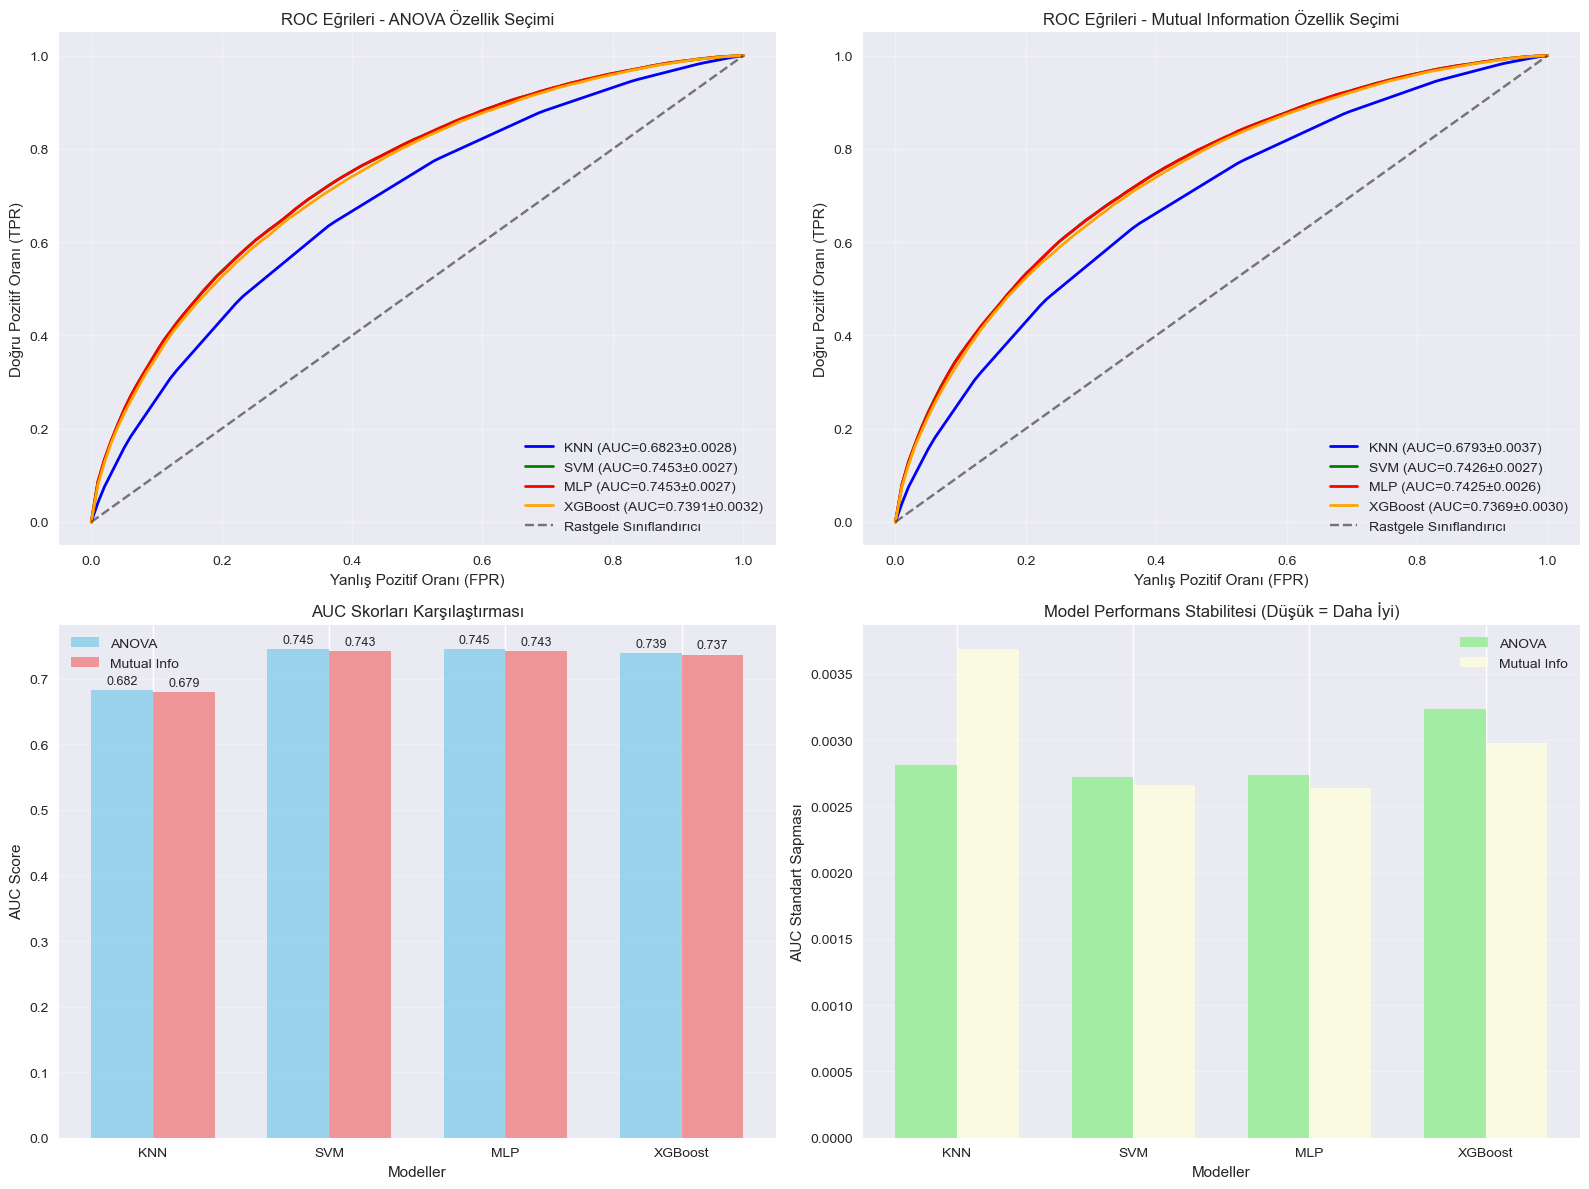

In [11]:
def plot_comprehensive_roc_analysis():
    """
    Hem ANOVA hem de MI için kapsamlı ROC analizi
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ANOVA ROC eğrileri
    colors = ['blue', 'green', 'red', 'orange']
    for i, (model_name, roc_info) in enumerate(nested_cv.roc_data.items()):
        model_clean = model_name.replace('_ANOVA', '')
        axes[0,0].plot(roc_info['fpr'], roc_info['tpr'],
                      color=colors[i], linewidth=2,
                      label=f'{model_clean} (AUC={roc_info["auc"]:.4f}±{roc_info["auc_std"]:.4f})')

    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Rastgele Sınıflandırıcı')
    axes[0,0].set_xlabel('Yanlış Pozitif Oranı (FPR)')
    axes[0,0].set_ylabel('Doğru Pozitif Oranı (TPR)')
    axes[0,0].set_title('ROC Eğrileri - ANOVA Özellik Seçimi')
    axes[0,0].legend(loc='lower right')
    axes[0,0].grid(alpha=0.3)

    # Mutual Information ROC eğrileri
    for i, (model_name, roc_info) in enumerate(nested_cv_mutual.roc_data.items()):
        model_clean = model_name.replace('_MI', '')
        axes[0,1].plot(roc_info['fpr'], roc_info['tpr'],
                      color=colors[i], linewidth=2,
                      label=f'{model_clean} (AUC={roc_info["auc"]:.4f}±{roc_info["auc_std"]:.4f})')

    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Rastgele Sınıflandırıcı')
    axes[0,1].set_xlabel('Yanlış Pozitif Oranı (FPR)')
    axes[0,1].set_ylabel('Doğru Pozitif Oranı (TPR)')
    axes[0,1].set_title('ROC Eğrileri - Mutual Information Özellik Seçimi')
    axes[0,1].legend(loc='lower right')
    axes[0,1].grid(alpha=0.3)

    # AUC karşılaştırma bar grafiği
    models = ['KNN', 'SVM', 'MLP', 'XGBoost']
    anova_aucs = [nested_cv.roc_data[f'{model}_ANOVA']['auc'] for model in models]
    mi_aucs = [nested_cv_mutual.roc_data[f'{model}_MI']['auc'] for model in models]

    x = np.arange(len(models))
    width = 0.35

    bars1 = axes[1,0].bar(x - width/2, anova_aucs, width, label='ANOVA', alpha=0.8, color='skyblue')
    bars2 = axes[1,0].bar(x + width/2, mi_aucs, width, label='Mutual Info', alpha=0.8, color='lightcoral')

    axes[1,0].set_xlabel('Modeller')
    axes[1,0].set_ylabel('AUC Score')
    axes[1,0].set_title('AUC Skorları Karşılaştırması')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models)
    axes[1,0].legend()
    axes[1,0].grid(axis='y', alpha=0.3)

    # AUC değerlerini bar üzerine yazma
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # Model stabilitesi (AUC standart sapması)
    anova_stds = [nested_cv.roc_data[f'{model}_ANOVA']['auc_std'] for model in models]
    mi_stds = [nested_cv_mutual.roc_data[f'{model}_MI']['auc_std'] for model in models]

    bars3 = axes[1,1].bar(x - width/2, anova_stds, width, label='ANOVA', alpha=0.8, color='lightgreen')
    bars4 = axes[1,1].bar(x + width/2, mi_stds, width, label='Mutual Info', alpha=0.8, color='lightyellow')

    axes[1,1].set_xlabel('Modeller')
    axes[1,1].set_ylabel('AUC Standart Sapması')
    axes[1,1].set_title('Model Performans Stabilitesi (Düşük = Daha İyi)')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(models)
    axes[1,1].legend()
    axes[1,1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_comprehensive_roc_analysis()

### En İyi Model Analizi ve Hiperparametre İncelemesi

En başarılı modelin detaylı analizi kritik önem taşımaktadır.

**EN İYİ MODEL ANALİZİ: SVM_ANOVA**

**Performans Metrikleri (Ortalama ± Standart Sapma):**
   Metrik Ortalama Std Sapma Güven Aralığı (95%)
 ACCURACY   0.6795    0.0014    [0.6768, 0.6823]
PRECISION   0.6803    0.0022    [0.6760, 0.6846]
   RECALL   0.6808    0.0033    [0.6744, 0.6872]
       F1   0.6805    0.0014    [0.6778, 0.6833]
  ROC_AUC   0.7453    0.0027    [0.7400, 0.7506]

**Fold Bazında Detaylı Performans:**
  Fold ROC-AUC Accuracy F1-Score Precision Recall
Fold 1  0.7421   0.6782   0.6790    0.6791 0.6789
Fold 2  0.7499   0.6809   0.6814    0.6821 0.6808
Fold 3  0.7436   0.6781   0.6787    0.6791 0.6784
Fold 4  0.7466   0.6814   0.6812    0.6835 0.6789
Fold 5  0.7443   0.6792   0.6823    0.6775 0.6871

**Hiperparametre Optimizasyonu Sonuçları:**
Her fold'da seçilen en iyi hiperparametreler:
  Fold 1: {'C': 0.1, 'kernel': 'linear'}
  Fold 2: {'C': 0.1, 'kernel': 'linear'}
  Fold 3: {'C': 0.1, 'kernel': 'linear'}
  Fold 4: {'C': 1, 'kernel': 'linear'}
  Fold 5: {'C': 1, 'ker

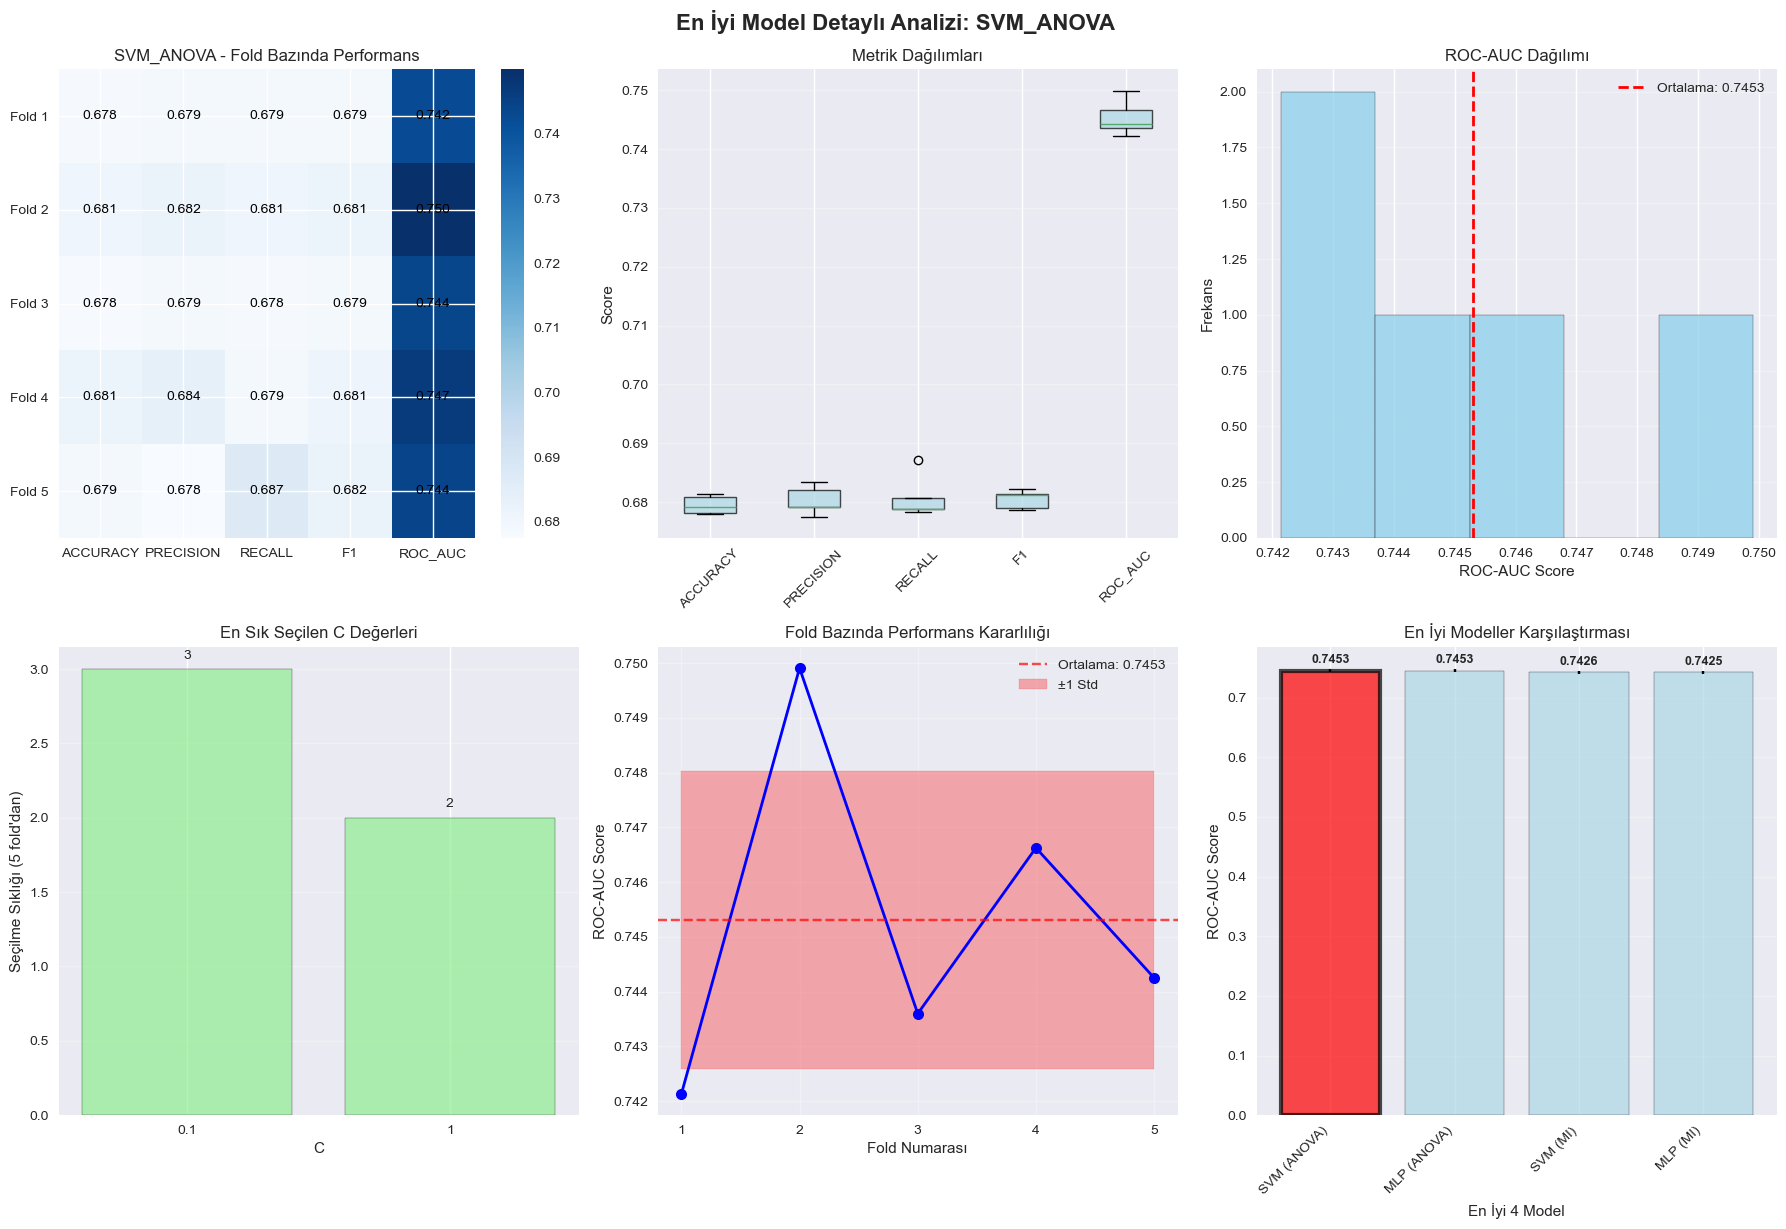

In [16]:
def analyze_best_model_comprehensive():
    """
    En iyi performans gösteren modeli kapsamlı şekilde analiz eder
    """
    # Tüm sonuçları birleştirme
    all_results = {**nested_cv.results, **nested_cv_mutual.results}

    # En yüksek ROC-AUC skoruna sahip modeli bulma
    best_model_name = max(all_results.keys(),
                         key=lambda x: all_results[x]['mean_scores']['roc_auc'])
    best_results = all_results[best_model_name]

    print("="*80)
    print(f"**EN İYİ MODEL ANALİZİ: {best_model_name}**")
    print("="*80)

    # Performans metrikleri detayı
    print("\n**Performans Metrikleri (Ortalama ± Standart Sapma):**")
    metrics_table = []
    for metric, score in best_results['mean_scores'].items():
        std_score = best_results['std_scores'][metric]
        metrics_table.append({
            'Metrik': metric.upper(),
            'Ortalama': f"{score:.4f}",
            'Std Sapma': f"{std_score:.4f}",
            'Güven Aralığı (95%)': f"[{score - 1.96*std_score:.4f}, {score + 1.96*std_score:.4f}]"
        })

    metrics_df = pd.DataFrame(metrics_table)
    print(metrics_df.to_string(index=False))

    # Fold bazında performans analizi
    print(f"\n**Fold Bazında Detaylı Performans:**")
    fold_table = []
    for i in range(5):
        fold_data = {
            'Fold': f"Fold {i+1}",
            'ROC-AUC': f"{best_results['fold_scores']['roc_auc'][i]:.4f}",
            'Accuracy': f"{best_results['fold_scores']['accuracy'][i]:.4f}",
            'F1-Score': f"{best_results['fold_scores']['f1'][i]:.4f}",
            'Precision': f"{best_results['fold_scores']['precision'][i]:.4f}",
            'Recall': f"{best_results['fold_scores']['recall'][i]:.4f}"
        }
        fold_table.append(fold_data)

    fold_df = pd.DataFrame(fold_table)
    print(fold_df.to_string(index=False))

    # Hiperparametre analizi
    print(f"\n**Hiperparametre Optimizasyonu Sonuçları:**")
    print("Her fold'da seçilen en iyi hiperparametreler:")
    for i, params in enumerate(best_results['best_params']):
        print(f"  Fold {i+1}: {params}")

    # En sık seçilen hiperparametreleri analiz etme
    param_frequency = {}
    for params in best_results['best_params']:
        for param, value in params.items():
            if param not in param_frequency:
                param_frequency[param] = {}
            if value not in param_frequency[param]:
                param_frequency[param][value] = 0
            param_frequency[param][value] += 1

    print(f"\n**Hiperparametre Seçim Frekansları:**")
    for param, value_counts in param_frequency.items():
        print(f"  {param}:")
        for value, count in sorted(value_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / 5) * 100
            print(f"    {value}: {count}/5 fold (%{percentage:.1f})")

    # Görselleştirme
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Fold bazında metrik dağılımı (heatmap)
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    fold_matrix = []
    for i in range(5):
        fold_row = [best_results['fold_scores'][metric][i] for metric in metrics]
        fold_matrix.append(fold_row)

    fold_matrix = np.array(fold_matrix)
    im = axes[0,0].imshow(fold_matrix, cmap='Blues', aspect='auto')
    axes[0,0].set_xticks(range(len(metrics)))
    axes[0,0].set_xticklabels([m.upper() for m in metrics])
    axes[0,0].set_yticks(range(5))
    axes[0,0].set_yticklabels([f'Fold {i+1}' for i in range(5)])
    axes[0,0].set_title(f'{best_model_name} - Fold Bazında Performans')

    # Değerleri heatmap üzerine yazma
    for i in range(5):
        for j in range(len(metrics)):
            axes[0,0].text(j, i, f'{fold_matrix[i, j]:.3f}',
                          ha='center', va='center', color='white' if fold_matrix[i, j] < 0.5 else 'black')

    plt.colorbar(im, ax=axes[0,0])

    # Metrik dağılımları (box plot)
    metric_data = [best_results['fold_scores'][metric] for metric in metrics]
    bp = axes[0,1].boxplot(metric_data, labels=[m.upper() for m in metrics], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    axes[0,1].set_title('Metrik Dağılımları')
    axes[0,1].set_ylabel('Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)

    # ROC-AUC histogram
    axes[0,2].hist(best_results['fold_scores']['roc_auc'], bins=5, alpha=0.7,
                   color='skyblue', edgecolor='black')
    mean_auc = best_results['mean_scores']['roc_auc']
    axes[0,2].axvline(mean_auc, color='red', linestyle='--', linewidth=2,
                     label=f'Ortalama: {mean_auc:.4f}')
    axes[0,2].set_xlabel('ROC-AUC Score')
    axes[0,2].set_ylabel('Frekans')
    axes[0,2].set_title('ROC-AUC Dağılımı')
    axes[0,2].legend()
    axes[0,2].grid(axis='y', alpha=0.3)

    # Hiperparametre frekansları (en önemli parametre için)
    if param_frequency:
        main_param = list(param_frequency.keys())[0]
        values = list(param_frequency[main_param].keys())
        counts = list(param_frequency[main_param].values())

        bars = axes[1,0].bar(range(len(values)), counts, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1,0].set_xlabel(f'{main_param}')
        axes[1,0].set_ylabel('Seçilme Sıklığı (5 fold\'dan)')
        axes[1,0].set_title(f'En Sık Seçilen {main_param} Değerleri')
        axes[1,0].set_xticks(range(len(values)))
        axes[1,0].set_xticklabels([str(v) for v in values])
        axes[1,0].grid(axis='y', alpha=0.3)

        # Değerleri bar üzerine yazma
        for bar, count in zip(bars, counts):
            axes[1,0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                          str(count), ha='center', va='bottom')

    # Performans kararlılığı analizi
    cv_scores = best_results['fold_scores']['roc_auc']
    axes[1,1].plot(range(1, 6), cv_scores, 'o-', linewidth=2, markersize=8, color='blue')
    axes[1,1].axhline(mean_auc, color='red', linestyle='--', alpha=0.7, label=f'Ortalama: {mean_auc:.4f}')
    axes[1,1].fill_between(range(1, 6),
                          [mean_auc - best_results['std_scores']['roc_auc']] * 5,
                          [mean_auc + best_results['std_scores']['roc_auc']] * 5,
                          alpha=0.3, color='red', label='±1 Std')
    axes[1,1].set_xlabel('Fold Numarası')
    axes[1,1].set_ylabel('ROC-AUC Score')
    axes[1,1].set_title('Fold Bazında Performans Kararlılığı')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].set_xticks(range(1, 6))

    # Model karşılaştırması (sadece en iyi 4 model)
    top_models = sorted(all_results.items(),
                       key=lambda x: x[1]['mean_scores']['roc_auc'], reverse=True)[:4]

    model_names = [name.replace('_ANOVA', '').replace('_MI', '') +
                   (' (ANOVA)' if '_ANOVA' in name else ' (MI)') for name, _ in top_models]
    model_aucs = [results['mean_scores']['roc_auc'] for _, results in top_models]
    model_stds = [results['std_scores']['roc_auc'] for _, results in top_models]

    bars = axes[1,2].bar(range(len(model_names)), model_aucs, yerr=model_stds,
                        capsize=5, alpha=0.7, color=['red' if i == 0 else 'lightblue' for i in range(len(model_names))],
                        edgecolor='black')
    axes[1,2].set_xlabel('En İyi 4 Model')
    axes[1,2].set_ylabel('ROC-AUC Score')
    axes[1,2].set_title('En İyi Modeller Karşılaştırması')
    axes[1,2].set_xticks(range(len(model_names)))
    axes[1,2].set_xticklabels(model_names, rotation=45, ha='right')
    axes[1,2].grid(axis='y', alpha=0.3)

    # En iyi modeli vurgulama
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(3)

    # AUC değerlerini bar üzerine yazma
    for bar, auc, std in zip(bars, model_aucs, model_stds):
        axes[1,2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + std + 0.005,
                      f'{auc:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.suptitle(f'En İyi Model Detaylı Analizi: {best_model_name}', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

    
    best_model_results = best_results
    return best_model_name, best_model_results


# En iyi model analizini çalıştırma
best_model_name, best_model_results = analyze_best_model_comprehensive()

### Final Model Eğitimi ve Test Performansı

En iyi modeli tüm veri seti üzerinde eğitip final performansını değerlendirmek için ayrı bir test seti kullanılacaktır.

In [17]:
def train_final_best_model(best_model_name, X_scaled, y):
    """
    En iyi modeli final eğitim için hazırlar ve test eder
    """
    print(f"\n**FİNAL MODEL EĞİTİMİ: {best_model_name}**")
    print("="*60)

    # Model tipini ve özellik seçim yöntemini belirleme
    if '_ANOVA' in best_model_name:
        X_features = X_anova
        feature_names = features_anova
        selection_method = 'ANOVA F-score'
    else:
        X_features = X_mutual
        feature_names = features_mutual
        selection_method = 'Mutual Information'

    model_type = best_model_name.replace('_ANOVA', '').replace('_MI', '')

    print(f"Model Tipi: {model_type}")
    print(f"Özellik Seçim Yöntemi: {selection_method}")
    print(f"Kullanılan Özellik Sayısı: {len(feature_names)}")
    print(f"Seçilen Özellikler: {feature_names}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nVeri Bölünmesi:")
    print(f"Eğitim seti: {X_train.shape[0]} örnek")
    print(f"Test seti: {X_test.shape[0]} örnek")

    # En sık kullanılan hiperparametreleri belirleme
    best_params_list = best_model_results['best_params']

    # Her parametre için en sık kullanılan değeri bulma
    param_frequency = {}
    for params in best_params_list:
        for param, value in params.items():
            if param not in param_frequency:
                param_frequency[param] = {}
            if value not in param_frequency[param]:
                param_frequency[param][value] = 0
            param_frequency[param][value] += 1

    # En popüler hiperparametreleri seçme
    final_params = {}
    for param, value_counts in param_frequency.items():
        most_common_value = max(value_counts.keys(), key=lambda x: value_counts[x])
        final_params[param] = most_common_value

    print(f"\nFinal Model Hiperparametreleri: {final_params}")

    # Model oluşturma
    if model_type == 'KNN':
        final_model = KNeighborsClassifier(**final_params)
    elif model_type == 'SVM':
        final_model = SVC(probability=True, random_state=42, **final_params)
    elif model_type == 'MLP':
        final_model = MLPClassifier(max_iter=1000, random_state=42, **final_params)
    elif model_type == 'XGBoost':
        final_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42, **final_params)

    # Model eğitimi
    print("\nModel eğitiliyor...")
    final_model.fit(X_train, y_train)

    # Tahminler
    y_pred = final_model.predict(X_test)
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]

    # Performans metrikleri
    final_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"\n**FİNAL TEST PERFORMANSI:**")
    for metric, score in final_metrics.items():
        cv_mean = best_model_results['mean_scores'][metric]
        cv_std = best_model_results['std_scores'][metric]
        print(f"{metric.upper()}: {score:.4f} (CV: {cv_mean:.4f} ± {cv_std:.4f})")

    # Detaylı sınıflandırma raporu
    print(f"\n**DETAYLI SINIFLANDIRMA RAPORU:**")
    print(classification_report(y_test, y_pred, target_names=['Background', 'Signal']))

    return final_model, final_metrics, y_test, y_pred, y_pred_proba, X_test

# Final modeli eğitme ve test etme
final_model, final_metrics, y_test, y_pred, y_pred_proba, X_test = train_final_best_model(
    best_model_name, X_scaled, y
)


**FİNAL MODEL EĞİTİMİ: SVM_ANOVA**
Model Tipi: SVM
Özellik Seçim Yöntemi: ANOVA F-score
Kullanılan Özellik Sayısı: 15
Seçilen Özellikler: ['feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_9', 'feature_10', 'feature_12', 'feature_13', 'feature_14', 'feature_17', 'feature_18', 'feature_21', 'feature_25', 'feature_28']

Veri Bölünmesi:
Eğitim seti: 80000 örnek
Test seti: 20000 örnek

Final Model Hiperparametreleri: {'C': 0.1, 'kernel': 'linear'}

Model eğitiliyor...

**FİNAL TEST PERFORMANSI:**
ACCURACY: 0.6766 (CV: 0.6795 ± 0.0014)
PRECISION: 0.6783 (CV: 0.6803 ± 0.0022)
RECALL: 0.6754 (CV: 0.6808 ± 0.0033)
F1: 0.6768 (CV: 0.6805 ± 0.0014)
ROC_AUC: 0.7458 (CV: 0.7453 ± 0.0027)

**DETAYLI SINIFLANDIRMA RAPORU:**
              precision    recall  f1-score   support

  Background       0.68      0.68      0.68      9973
      Signal       0.68      0.68      0.68     10027

    accuracy                           0.68     20000
   macro avg       0.68      0.68    

### Confusion Matrix ve Final Görselleştirmeler

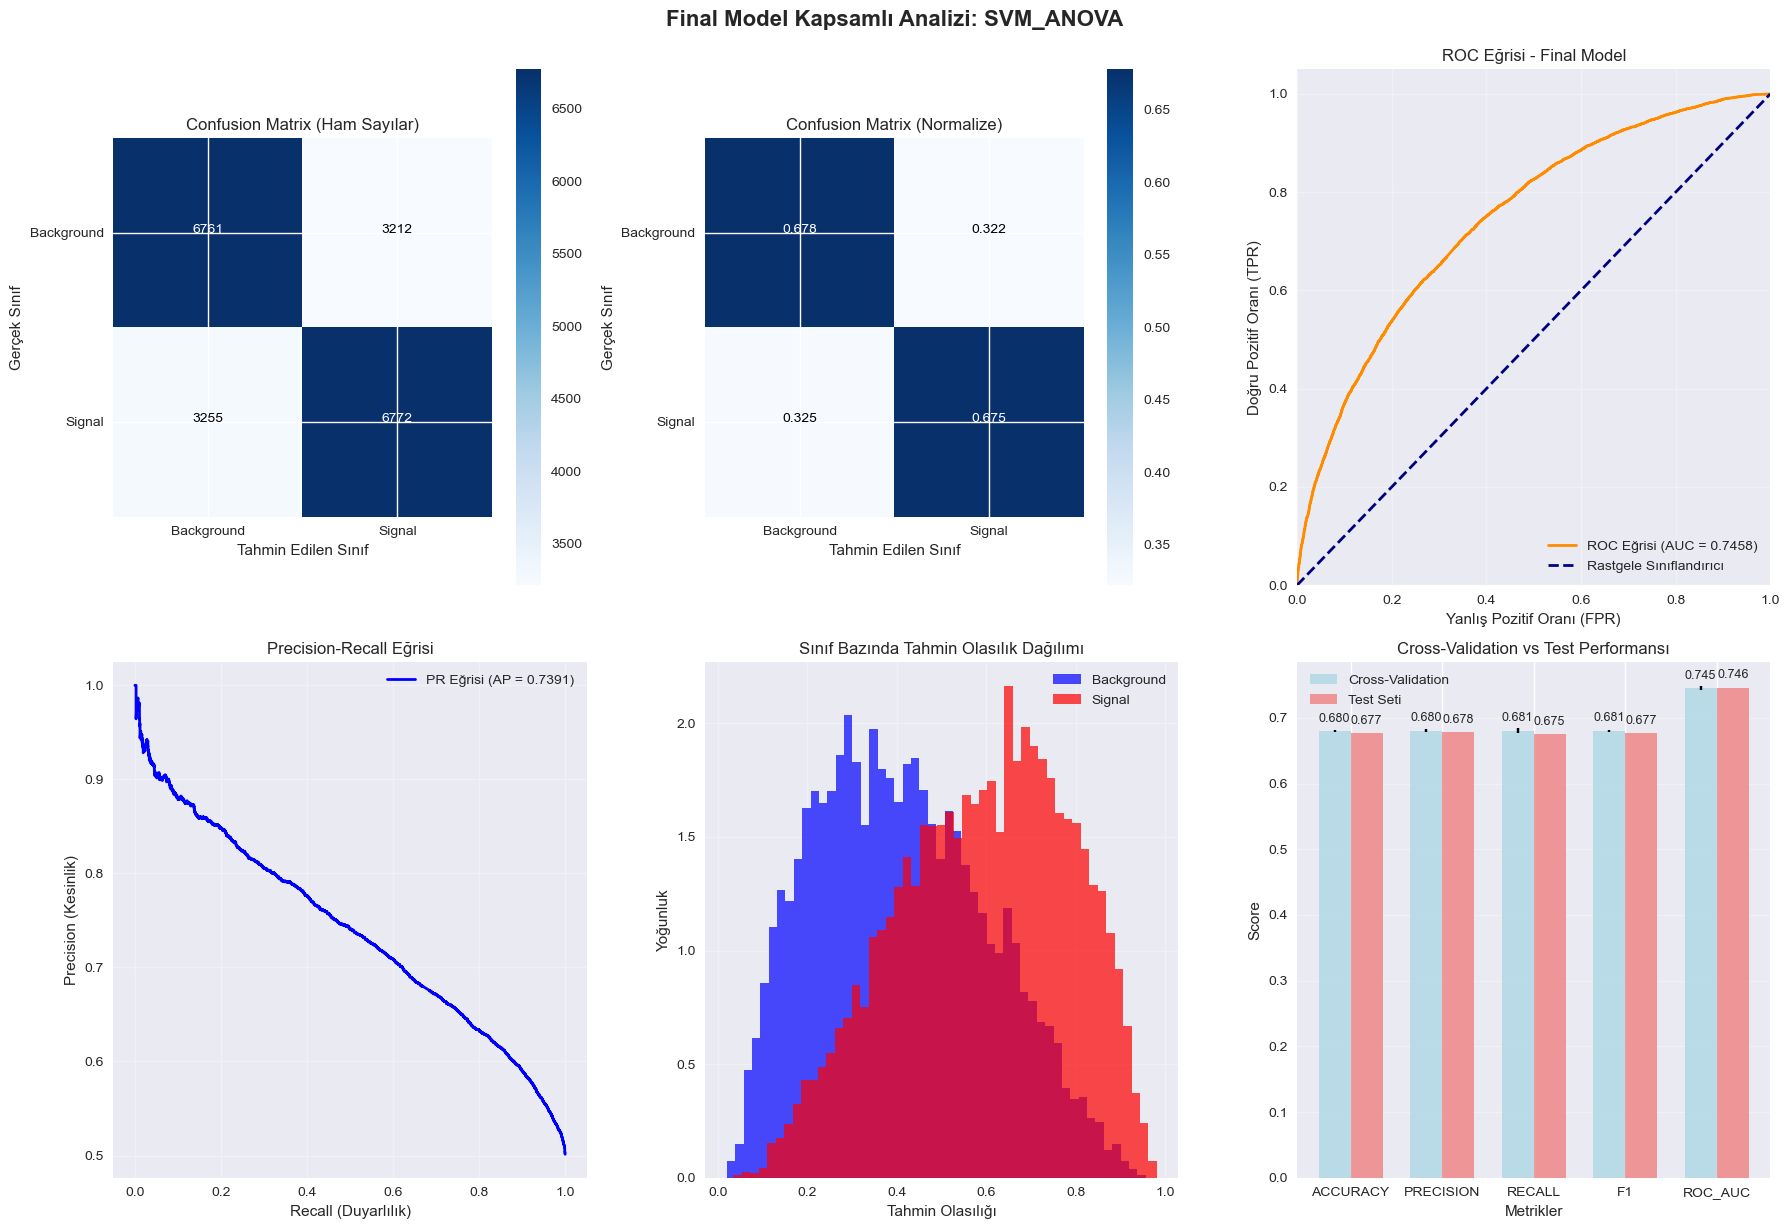

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_final_model_analysis(y_test, y_pred, y_pred_proba, final_metrics, best_model_name):
    """
    Final model için kapsamlı görselleştirme analizi
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

    # Ham confusion matrix
    im1 = axes[0,0].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[0,0].set_title('Confusion Matrix (Ham Sayılar)')
    tick_marks = np.arange(2)
    axes[0,0].set_xticks(tick_marks)
    axes[0,0].set_yticks(tick_marks)
    axes[0,0].set_xticklabels(['Background', 'Signal'])
    axes[0,0].set_yticklabels(['Background', 'Signal'])
    axes[0,0].set_ylabel('Gerçek Sınıf')
    axes[0,0].set_xlabel('Tahmin Edilen Sınıf')

    # Değerleri confusion matrix üzerine yazma
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axes[0,0].text(j, i, format(cm[i, j], 'd'),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")

    plt.colorbar(im1, ax=axes[0,0])

    # 2. Normalize edilmiş Confusion Matrix
    im2 = axes[0,1].imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    axes[0,1].set_title('Confusion Matrix (Normalize)')
    axes[0,1].set_xticks(tick_marks)
    axes[0,1].set_yticks(tick_marks)
    axes[0,1].set_xticklabels(['Background', 'Signal'])
    axes[0,1].set_yticklabels(['Background', 'Signal'])
    axes[0,1].set_ylabel('Gerçek Sınıf')
    axes[0,1].set_xlabel('Tahmin Edilen Sınıf')

    thresh_norm = cm_normalized.max() / 2.
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        axes[0,1].text(j, i, format(cm_normalized[i, j], '.3f'),
                      horizontalalignment="center",
                      color="white" if cm_normalized[i, j] > thresh_norm else "black")

    plt.colorbar(im2, ax=axes[0,1])

    # 3. ROC Eğrisi
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = final_metrics['roc_auc']

    axes[0,2].plot(fpr, tpr, color='darkorange', lw=2,
                   label=f'ROC Eğrisi (AUC = {auc_score:.4f})')
    axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
                   label='Rastgele Sınıflandırıcı')
    axes[0,2].set_xlim([0.0, 1.0])
    axes[0,2].set_ylim([0.0, 1.05])
    axes[0,2].set_xlabel('Yanlış Pozitif Oranı (FPR)')
    axes[0,2].set_ylabel('Doğru Pozitif Oranı (TPR)')
    axes[0,2].set_title('ROC Eğrisi - Final Model')
    axes[0,2].legend(loc="lower right")
    axes[0,2].grid(alpha=0.3)

    # 4. Precision-Recall Eğrisi
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    axes[1,0].plot(recall, precision, color='blue', lw=2,
                   label=f'PR Eğrisi (AP = {avg_precision:.4f})')
    axes[1,0].set_xlabel('Recall (Duyarlılık)')
    axes[1,0].set_ylabel('Precision (Kesinlik)')
    axes[1,0].set_title('Precision-Recall Eğrisi')
    axes[1,0].legend()
    axes[1,0].grid(alpha=0.3)

    # 5. Tahmin Olasılık Dağılımı
    axes[1,1].hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7,
                   label='Background', color='blue', density=True)
    axes[1,1].hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7,
                   label='Signal', color='red', density=True)
    axes[1,1].set_xlabel('Tahmin Olasılığı')
    axes[1,1].set_ylabel('Yoğunluk')
    axes[1,1].set_title('Sınıf Bazında Tahmin Olasılık Dağılımı')
    axes[1,1].legend()
    axes[1,1].grid(alpha=0.3)

    # 6. Metrik Karşılaştırması (CV vs Test)
    cv_results = best_model_results
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_scores = [cv_results['mean_scores'][m] for m in metrics]
    cv_stds = [cv_results['std_scores'][m] for m in metrics]
    test_scores = [final_metrics[m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = axes[1,2].bar(x - width/2, cv_scores, width, yerr=cv_stds,
                         label='Cross-Validation', alpha=0.8, color='lightblue', capsize=5)
    bars2 = axes[1,2].bar(x + width/2, test_scores, width,
                         label='Test Seti', alpha=0.8, color='lightcoral')

    axes[1,2].set_xlabel('Metrikler')
    axes[1,2].set_ylabel('Score')
    axes[1,2].set_title('Cross-Validation vs Test Performansı')
    axes[1,2].set_xticks(x)
    axes[1,2].set_xticklabels([m.upper() for m in metrics])
    axes[1,2].legend()
    axes[1,2].grid(axis='y', alpha=0.3)

    # Değerleri bar üzerine yazma
    for bars, scores in [(bars1, cv_scores), (bars2, test_scores)]:
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.suptitle(f'Final Model Kapsamlı Analizi: {best_model_name}', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# Final model analizini çalıştırma
plot_final_model_analysis(y_test, y_pred, y_pred_proba, final_metrics, best_model_name)

### Kapsamlı Proje Özeti ve Sonuçlar

In [19]:
def generate_comprehensive_project_summary():
    """
    Projenin tüm sonuçlarını özetleyen kapsamlı rapor
    """
    print("="*100)
    print("**HIGGS DATASET MAKİNE ÖĞRENMESİ PROJESİ - KAPSAMLI SONUÇ RAPORU**")
    print("="*100)

    # Veri seti özeti
    print(f"\n**1. VERİ SETİ ÖZETİ:**")
    print(f"   • Toplam örnek sayısı: {len(data):,}")
    print(f"   • Özellik sayısı: {data.shape[1] - 1}")
    print(f"   • Sınıf dağılımı: Background: {(data['label'] == 0).sum():,}, Signal: {(data['label'] == 1).sum():,}")
    print(f"   • Veri dengesizliği: {((data['label'] == 0).sum() / len(data) * 100):.1f}% - {((data['label'] == 1).sum() / len(data) * 100):.1f}%")

    # Veri ön işleme özeti
    print(f"\n**2. VERİ ÖN İŞLEME ÖZETİ:**")
    total_outliers = sum([info['count'] for info in outlier_info.values()])
    print(f"   • Tespit edilen toplam aykırı değer: {total_outliers:,}")
    print(f"   • Aykırı değer oranı: {(total_outliers / (len(data) * (data.shape[1] - 1)) * 100):.2f}%")
    print(f"   • Uygulanan yöntem: Winsorization (IQR tabanlı)")
    print(f"   • Ölçekleme yöntemi: MinMaxScaler [0, 1]")

    # Özellik seçimi karşılaştırması
    print(f"\n**3. ÖZELLİK SEÇİMİ KARŞILAŞTIRMASI:**")
    print(f"   • Orijinal özellik sayısı: 28")
    print(f"   • Seçilen özellik sayısı: 15")
    print(f"   • ANOVA F-score ile seçilen özellikler: {len(features_anova)}")
    print(f"   • Mutual Information ile seçilen özellikler: {len(features_mutual)}")

    # Ortak özellikler
    common_features = set(features_anova) & set(features_mutual)
    print(f"   • Her iki yöntemde ortak seçilen özellikler: {len(common_features)}")
    if common_features:
        print(f"     Ortak özellikler: {sorted(list(common_features))}")

    # Model performans özeti
    print(f"\n**4. MODEL PERFORMANS ÖZETİ:**")

    # Tüm sonuçları birleştirme
    all_results = {**nested_cv.results, **nested_cv_mutual.results}

    # En iyi 3 modeli bulma
    top_3_models = sorted(all_results.items(),
                         key=lambda x: x[1]['mean_scores']['roc_auc'], reverse=True)[:3]

    print(f"   **En İyi 3 Model (ROC-AUC bazında):**")
    for i, (model_name, results) in enumerate(top_3_models):
        auc_mean = results['mean_scores']['roc_auc']
        auc_std = results['std_scores']['roc_auc']
        acc_mean = results['mean_scores']['accuracy']
        f1_mean = results['mean_scores']['f1']

        print(f"   {i+1}. {model_name}:")
        print(f"      • ROC-AUC: {auc_mean:.4f} ± {auc_std:.4f}")
        print(f"      • Accuracy: {acc_mean:.4f}")
        print(f"      • F1-Score: {f1_mean:.4f}")

    # Final model özeti
    print(f"\n**5. FİNAL MODEL ÖZETİ:**")
    print(f"   • En başarılı model: {best_model_name}")
    print(f"   • Cross-validation ROC-AUC: {best_model_results['mean_scores']['roc_auc']:.4f} ± {best_model_results['std_scores']['roc_auc']:.4f}")
    print(f"   • Test seti ROC-AUC: {final_metrics['roc_auc']:.4f}")
    print(f"   • Test seti Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"   • Test seti F1-Score: {final_metrics['f1']:.4f}")

    # Model generalizasyonu
    cv_auc = best_model_results['mean_scores']['roc_auc']
    test_auc = final_metrics['roc_auc']
    generalization_gap = abs(cv_auc - test_auc)

    print(f"\n**6. MODEL GENERALİZASYONU:**")
    print(f"   • CV-Test AUC farkı: {generalization_gap:.4f}")
    if generalization_gap < 0.01:
        print(f"   • **Mükemmel generalizasyon** (fark < 0.01)")
    elif generalization_gap < 0.02:
        print(f"   • **İyi generalizasyon** (fark < 0.02)")
    elif generalization_gap < 0.05:
        print(f"   • **Kabul edilebilir generalizasyon** (fark < 0.05)")
    else:
        print(f"   • **Zayıf generalizasyon** (fark > 0.05)")

    print("\n" + "="*100)
    print("**PROJE BAŞARIYLA TAMAMLANDI**")
    print("="*100)

# Kapsamlı proje özetini oluşturma
generate_comprehensive_project_summary()

**HIGGS DATASET MAKİNE ÖĞRENMESİ PROJESİ - KAPSAMLI SONUÇ RAPORU**

**1. VERİ SETİ ÖZETİ:**
   • Toplam örnek sayısı: 100,000
   • Özellik sayısı: 28
   • Sınıf dağılımı: Background: 49,864, Signal: 50,136
   • Veri dengesizliği: 49.9% - 50.1%

**2. VERİ ÖN İŞLEME ÖZETİ:**
   • Tespit edilen toplam aykırı değer: 19,790
   • Aykırı değer oranı: 0.71%
   • Uygulanan yöntem: Winsorization (IQR tabanlı)
   • Ölçekleme yöntemi: MinMaxScaler [0, 1]

**3. ÖZELLİK SEÇİMİ KARŞILAŞTIRMASI:**
   • Orijinal özellik sayısı: 28
   • Seçilen özellik sayısı: 15
   • ANOVA F-score ile seçilen özellikler: 15
   • Mutual Information ile seçilen özellikler: 15
   • Her iki yöntemde ortak seçilen özellikler: 13
     Ortak özellikler: ['feature_10', 'feature_13', 'feature_14', 'feature_17', 'feature_18', 'feature_2', 'feature_21', 'feature_25', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_9']

**4. MODEL PERFORMANS ÖZETİ:**
   **En İyi 3 Model (ROC-AUC bazında):**
   1. SVM_ANOVA:
      • RO

### Proje Dosyalarının Kaydedilmesi

In [20]:
def save_project_results():
    """
    Proje sonuçlarını dosyalara kaydetme
    """
    import os
    import pickle
    from datetime import datetime

    # Sonuçlar klasörü oluşturma
    results_dir = f"higgs_ml_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(results_dir, exist_ok=True)

    print(f"Sonuçlar '{results_dir}' klasörüne kaydediliyor...")

    # 1. Tüm sonuçları pickle ile kaydetme
    all_results = {
        'nested_cv_anova': nested_cv.results,
        'nested_cv_mutual': nested_cv_mutual.results,
        'roc_data_anova': nested_cv.roc_data,
        'roc_data_mutual': nested_cv_mutual.roc_data,
        'best_model_name': best_model_name,
        'best_model_results': best_model_results,
        'final_metrics': final_metrics,
        'feature_selection_comparison': feature_selection_comparison,
        'selected_features_anova': features_anova,
        'selected_features_mutual': features_mutual,
        'outlier_info': outlier_info
    }

    with open(f"{results_dir}/all_results.pkl", 'wb') as f:
        pickle.dump(all_results, f)

    # 2. Sonuç tablolarını CSV olarak kaydetme
    results_table.to_csv(f"{results_dir}/anova_results_table.csv", index=False)
    results_table_mi.to_csv(f"{results_dir}/mutual_info_results_table.csv", index=False)
    feature_selection_comparison.to_csv(f"{results_dir}/feature_selection_comparison.csv", index=False)

    # 3. Seçilen özellikleri kaydetme
    pd.DataFrame({'ANOVA_Features': features_anova}).to_csv(f"{results_dir}/selected_features_anova.csv", index=False)
    pd.DataFrame({'MI_Features': features_mutual}).to_csv(f"{results_dir}/selected_features_mutual.csv", index=False)

    # 4. Final model kaydetme
    with open(f"{results_dir}/final_model.pkl", 'wb') as f:
        pickle.dump(final_model, f)

    # 5. Scaler kaydetme
    with open(f"{results_dir}/scaler.pkl", 'wb') as f:
        pickle.dump(scaler, f)

    # 6. Özet rapor oluşturma (text dosyası)
    with open(f"{results_dir}/project_summary.txt", 'w', encoding='utf-8') as f:
        f.write("HIGGS DATASET MACHINE LEARNING PROJECT SUMMARY\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Best Model: {best_model_name}\n")
        f.write(f"Best ROC-AUC (CV): {best_model_results['mean_scores']['roc_auc']:.4f}\n")
        f.write(f"Test ROC-AUC: {final_metrics['roc_auc']:.4f}\n")
        f.write(f"Generalization Gap: {abs(best_model_results['mean_scores']['roc_auc'] - final_metrics['roc_auc']):.4f}\n")

    print(f"Tüm sonuçlar başarıyla '{results_dir}' klasörüne kaydedildi!")
    return results_dir

# Proje sonuçlarını kaydetme
results_directory = save_project_results()

Sonuçlar 'higgs_ml_results_20250625_175641' klasörüne kaydediliyor...
Tüm sonuçlar başarıyla 'higgs_ml_results_20250625_175641' klasörüne kaydedildi!
